# 4. Internal Linear Combination (ILC) applied to wavelet coefficient maps across all frequency channels at each scale with multiprocessing

In [44]:
import math 
# import pys2let as ps 
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
from s2wav import filters
import healpy as hp
import numpy as np
import s2wav
import skyclean
import time
import math
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline 

### 4.1 Create the directory structure to store data

In [45]:
def check_and_create_ilc_directories():
    """
    Checks for the existence of a specific nested directory structure for ILC processing and creates any missing directories.
    This includes handling multiple levels of nested directories as shown in the provided folder structure.

    The structure checked is:
    - ILC
      - covariance_matrix
      - ILC_doubled_maps
      - ILC_processed_wavelet_maps
      - synthesized_ILC_MW_maps
      - wavelet_doubled
      - weight_vector_data
    """

    # Define the root directories
    # base_dir = "path_to_base_directory"  # Set this to your base directory path
    # ilc_dir = os.path.join(base_dir, "ILC")
    ilc_dir = "ILC"
    # List of directories under the ILC directory
    ilc_sub_dirs = ["covariance_matrix", "ILC_doubled_maps", "ILC_processed_wavelet_maps", "synthesized_ILC_MW_maps","wavelet_doubled","weight_vector_data"]

    # Create the ILC directory and its subdirectories
    create_directory(ilc_dir)
    for sub_dir in ilc_sub_dirs:
        create_directory(os.path.join(ilc_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed
check_and_create_ilc_directories()


Directory already exists: ILC
Directory already exists: ILC/covariance_matrix
Directory already exists: ILC/ILC_doubled_maps
Directory already exists: ILC/ILC_processed_wavelet_maps
Directory already exists: ILC/synthesized_ILC_MW_maps
Directory already exists: ILC/wavelet_doubled
Directory already exists: ILC/weight_vector_data


Dubuging the file_path

In [46]:
import os

frequencies = ['030','044','070','100','143','217','353','545','857']
scales      = [0,1,2,3,4,5,6]
realization_str = "0000"
component = "CSNT"  

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

print(f"Checking input wavelet coefficient map paths for component='{component}'\n")
missing_files = []

for freq in frequencies:
    for scale in scales:
        path = file_template.format(
            component=component,
            frequency=freq,
            scale=scale,
            realization=realization_str
        )
        exists = os.path.exists(path)
        print(f"{path}   {'✓' if exists else 'MISSING'}")
        if not exists:
            missing_files.append(path)

if missing_files:
    print("\nWARNING: Missing files detected:")
    for m in missing_files:
        print("  " + m)
else:
    print("\nAll files found ✅")


Checking input wavelet coefficient map paths for component='CSNT'

wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S0_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S1_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S2_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S3_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S4_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S5_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F030_S6_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F044_S0_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F044_S1_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F044_S2_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F044_S3_R0000.npy   ✓
wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_CSNT_F044_S4_R0000.npy   ✓
wavelet_t

### 4.2 ILC functions 

multiprocessing: 

(all scales, all frequencies)

double_and_save_wavelet_maps_MP: Double the resolution of the wavelet coefficient maps and save them.

calculate_covariance_matrix_MP: Calculates the covariance matrices for all given frequencies and saves them to 1 4d array (9,9,pixel dimension 1, pixel dimension 2).

(all scales)

trim_to_original: 
Trims the ILC doubled wavelet coefficient map to its original resolution.


In [47]:

def mw_alm_2_hp_alm(MW_alm, lmax):
    """
    Converts MW alm coefficients to HEALPix alm coefficients.

    Args:
        MW_alm (ndarray): 2D array of shape (Lmax, 2*Lmax-1) representing MW alm coefficients.
        lmax (int): Maximum multipole moment.

    Returns:
        ndarray: 1D array of HEALPix alm coefficients.
    """
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

def Single_Map_doubleworker(MW_Pix_Map):
    """
    Doubles the resolution of a single wavelet map.

    Args:
        MW_Pix_Map (ndarray): Wavelet pixel map to be doubled in resolution.

    Returns:
        ndarray: Doubled resolution wavelet map.
    """
    MW_alm = s2fft.forward(MW_Pix_Map, L=MW_Pix_Map.shape[1])
    L = MW_alm.shape[0]
    padded_alm = np.zeros((2*L-1, 2*(2*L-1)-1), dtype=np.complex128)
    
    inner_matrix_middle = MW_alm.shape[1] // 2
    outer_matrix_middle = padded_alm.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + MW_alm.shape[1]
      
    padded_alm[:MW_alm.shape[0], start_col:end_col] = MW_alm
    MW_Pix_Map_doubled = np.real(s2fft.inverse(padded_alm, L=padded_alm.shape[0]))
    
    return MW_Pix_Map_doubled

def load_frequency_data(file_template, frequencies, scales, realization, component):
    """
    Loads wavelet data from files for different frequencies and scales.

    Args:
        base_path (str): Base directory containing the wavelet files.
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): Realization identifier as a string.

    Returns:
        dict: Dictionary where keys are tuples (frequency, scale) and values are loaded wavelet data arrays.
    """
    
    frequency_data = {}
    realization = str(realization).zfill(4)
    for frequency in frequencies:
        for scale in scales:
            path = f"{file_template.format(frequency=frequency, scale=scale, realization=realization, component=component)}"
            # print(path)
            try:
                frequency_data[(frequency, scale)] = np.load(path)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}, realization {realization}")
    return frequency_data

def save_doubled_wavelet_map(args):
    """
    Helper function to save a doubled wavelet map.

    Args:
        args (tuple): (wavelet_map, frequency, scale, realization, component, path_template)
    """
    original_map, frequency, scale, realization, component, path_template = args
    doubled_map = Single_Map_doubleworker(original_map)
    save_path = path_template.format(
        component=component,
        frequency=frequency,
        scale=scale,
        realization=realization
    )
    np.save(save_path, doubled_map)


def double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization, component, path_template):
    """
    Doubles the resolution of the wavelet coefficient maps using multiprocessing.

    Args:
        original_wavelet_c_j (dict): Dictionary containing the original wavelet maps.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (str): The realization number for file naming.
        path_template (str): Template for saving the doubled wavelet maps.
    """
    tasks = [(original_wavelet_c_j[(i, j)], i, j, realization, component, path_template) for i in frequencies for j in scales]
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(save_doubled_wavelet_map, tasks)

def smoothed_covariance(MW_Map1, MW_Map2):
    """
    Computes covariance between two wavelet maps with smoothing.

    Args:
        MW_Map1 (ndarray): First wavelet coefficient map.
        MW_Map2 (ndarray): Second wavelet coefficient map.

    Returns:
        ndarray: Smoothed covariance map.
    """
    smoothing_lmax = MW_Map1.shape[0]
    map1 = np.real(MW_Map1)
    map2 = np.real(MW_Map2)
    R_MW_Pixel_map = np.multiply(map1, map2) + 0.j

    R_MW_alm = s2fft.forward(R_MW_Pixel_map, L=smoothing_lmax)
    nsamp = 1200.0
    lmax_at_scale_j = R_MW_alm.shape[0]
    npix = hp.nside2npix(1 << (int(0.5*lmax_at_scale_j)-1).bit_length())
    scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
    gauss_smooth = hp.gauss_beam(scale_fwhm, lmax=smoothing_lmax-1)
    MW_alm_beam_convolved = np.zeros(R_MW_alm.shape, dtype=np.complex128)

    for i in range(R_MW_alm.shape[1]):
        MW_alm_beam_convolved[:, i] = R_MW_alm[:, i] * gauss_smooth
    
    R_covariance_map = np.real(s2fft.inverse(MW_alm_beam_convolved, L=smoothing_lmax))
    return R_covariance_map


def compute_covariance(task):
    """
    Computes the covariance between two frequency maps at a given scale.
    
    Args:
    task (tuple): A tuple containing (i, fq, frequencies, scale, doubled_MW_wav_c_j).
    
    Returns:
    tuple: A tuple containing indices i, fq and the computed covariance matrix.
    """
    i, fq, frequencies, scale, doubled_MW_wav_c_j = task
    key_i = (frequencies[i], scale)
    key_fq = (frequencies[fq], scale)
    if key_i not in doubled_MW_wav_c_j or key_fq not in doubled_MW_wav_c_j:
        raise KeyError(f"Missing data for keys {key_i} or {key_fq}.")
    return i, fq, smoothed_covariance(doubled_MW_wav_c_j[key_i], doubled_MW_wav_c_j[key_fq])

def calculate_covariance_matrix_MP(frequencies, doubled_MW_wav_c_j, scale, realization, component, path_template):
    """
    Calculates the covariance matrices for all given frequencies and saves them to disk using a provided template.
    """

    if frequencies:
        sample_data = doubled_MW_wav_c_j.get((frequencies[0], scale))
        if sample_data is None:
            raise KeyError(f"Data for frequency '{frequencies[0]}' and scale '{scale}' is missing.")
        n_rows, n_cols = sample_data.shape
    else:
        raise ValueError("Frequency list is empty.")
    
    total_frequency = len(frequencies)
    full_array = np.zeros((total_frequency, total_frequency, n_rows, n_cols))
    
    # Calculate the covariance (keep your existing logic)
    tasks = [(i, fq, frequencies, scale, doubled_MW_wav_c_j) 
             for i in range(total_frequency) for fq in range(i, total_frequency)]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(compute_covariance, tasks)
        for result in results:
            i, fq, covariance_matrix = result
            full_array[i, fq] = covariance_matrix
    
    # Fill the symmetric part of the matrix
    for l1 in range(1, total_frequency):
        for l2 in range(l1):
            full_array[l1, l2] = full_array[l2, l1]

    # ✅ Fixed: include component in format to prevent KeyError
    f_str = '_'.join(frequencies)
    save_path = path_template.format(
        component=component,
        frequencies=f_str, 
        scale=scale, 
        realization=str(realization).zfill(4)   
    )
    np.save(save_path, full_array)

    return full_array


def compute_weight_vector(R, scale, realization, weight_vector_matrix_template):
    """
    Processes the given 4D matrix R by computing and saving the weight vectors for each matrix in the first two dimensions.
    
    Args:
        R (np.ndarray): The input covariance matrix, either 2D or 4D.
        scale (int): The scale index.
        realization (str): The realization identifier.
        weight_vector_matrix_template (str): Template for saving the weight vector matrices.

    Returns:
        Returns:
        inverses: (np.ndarray): An Array containing the inverse matrices
        weight_vectors (np.ndarray): A 3D Array containing the weight vector.
        The size of the first two dimensions of the weight vector is the size of the wavelet coefficient map at the given scale.
        The third dimension is the weight vector (The contribution from each frequency).
        Each element of the weight vector is a 1D array.
        singular_matrices_location (list): The locations of singular matrices.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    identity_vector = np.ones(subdim2, dtype=float)
    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                if R.ndim == 4:
                    inverse_matrix = np.linalg.inv(R_Pix[i, j])
                    inverses[i, j] = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors[i, j] = numerator / denominator
                else:
                    inverse_matrix = np.linalg.inv(R_Pix)
                    inverses = inverse_matrix
                    numerator = np.dot(inverse_matrix, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    weight_vectors = numerator / denominator
            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j
                )
                np.save(singular_matrix_path, R_Pix[i, j] if R.ndim == 4 else R_Pix)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(len(identity_vector))
                else:
                    weight_vectors = np.zeros(len(identity_vector))

    np.save(weight_vector_matrix_template.format(type="weight_vector", scale=scale, realization=realization), weight_vectors)
    return inverses, weight_vectors, singular_matrices_location

def process_matrix_worker(args):
    """
    Worker function for processing a single matrix in parallel.

    Args:
        args (tuple): Arguments including the matrix to process, indices, and paths for saving.
    """
    R_Pix_ij, i, j, scale, realization, identity_vector, inverses, weight_vectors, singular_matrices_location, component, component_name, path_template = args
    
    try:
        inverses[i, j] = np.linalg.inv(R_Pix_ij)
        numerator = np.dot(inverses[i, j], identity_vector)
        denominator = np.dot(numerator, identity_vector)
        weight_vectors[i, j] = numerator / denominator
    except np.linalg.LinAlgError:
        singular_matrices_location.append((i, j))
        np.save(path_template.format(type="inverse_singular_matrix", component=component, component_name=component_name, scale=scale, realization=realization, i=i, j=j), R_Pix_ij)
        weight_vectors[i, j] = np.zeros(len(identity_vector))




def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[scale][i, j], pix_vector)

def create_doubled_ILC_map(
    frequencies, scale, weight_vector_load, doubled_MW_wav_c_j,
    realization, component=None, constraint=False, component_name=None
):
    size = doubled_MW_wav_c_j[(frequencies[0], scale)].shape
    doubled_map = np.zeros(size)

    for i in range(size[0]):
        for j in range(size[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(
                i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j
            )

    # ✅ Save with proper file naming
    if constraint and component_name is not None:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy"
    else:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization}_MP.npy"

    np.save(path, doubled_map)
    return doubled_map


def trim_to_original(MW_Doubled_Map, scale, realization, component, component_name, path_template):
    """
    Trims the doubled MW map to its original resolution and saves it.

    Args:
        MW_Doubled_Map (ndarray): Doubled wavelet map to be trimmed.
        scale (int): Scale index.
        realization (str or int): The realization number for file naming.
        path_template (str): Template for saving the trimmed maps.

    Returns:
        ndarray: Trimmed wavelet map.
    """
    # Forward spherical transform
    MW_alm_doubled = s2fft.forward(MW_Doubled_Map, L=MW_Doubled_Map.shape[0])

    # Compute inner matrix shape
    inner_matrix_vertical = (MW_Doubled_Map.shape[0] + 1) // 2
    inner_matrix_horizontal = 2 * inner_matrix_vertical - 1

    inner_matrix_middle = inner_matrix_horizontal // 2
    outer_matrix_middle = MW_Doubled_Map.shape[1] // 2
    start_col = outer_matrix_middle - inner_matrix_middle
    end_col = start_col + inner_matrix_horizontal

    # Trim spherical harmonics to original resolution
    trimmed_alm = MW_alm_doubled[:inner_matrix_vertical, start_col:end_col]

    # Inverse transform to pixel domain
    MW_Pix_Map_original = s2fft.inverse(trimmed_alm, L=trimmed_alm.shape[0])[np.newaxis, ...]

    # Save trimmed map
    np.save(
        path_template.format(
            component=component,
            component_name=component_name,
            scale=scale,
            realization=str(realization).zfill(4)
        ),
        MW_Pix_Map_original
    )

    return MW_Pix_Map_original


def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if not is_MW_alm:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("MW alm shape:", original_map_alm.shape)
    else:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()



def synthesize_ILC_maps(trimmed_maps, realization, output_templates, L_max, N_directions):
    """
    Synthesizes ILC maps from trimmed wavelet maps, visualizes the results, and saves the synthesized maps.

    Args:
        trimmed_maps (list of np.ndarray): List of trimmed wavelet maps for different scales.
        realization (str): The realization identifier.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of directions for the directional wavelet filters.

    Returns:
        np.ndarray: The synthesized ILC map.
    """
    
    # Load the scaling coefficients using the template path
    f_scal = np.load(output_templates['f_scal'].format(realization=realization))

    # Create the directional filters
    filter = filters.filters_directional_vectorised(L_max, N_directions)

    # Perform the synthesis to obtain the ILC map
    MW_Pix = s2wav.synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter, N=N_directions)

    # Visualize the synthesized ILC map
    title = f"ILC CMB Map realization: {realization}"
    visualize_MW_Pix_map(MW_Pix, title)

    # Save the synthesized ILC map
    np.save(output_templates['synthesized_maps'].format(realization=realization), MW_Pix)
    
    return MW_Pix



def ILC_wav_coeff_maps_MP(file_template, frequencies, scales, realizations, output_templates, L_max, N_directions, component, component_name):
    
    """
    Processes wavelet maps for a range of realizations, including doubling, covariance calculation,
    matrix processing, and trimming to original resolution, using multiprocessing for efficiency
    where tasks are independent.

    Args:
        file_template (str): Template string for file paths with placeholders for frequency, scale, and realization.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realizations (list): List of realizations to process.
        output_templates (dict): Dictionary of output path templates for different processing steps.
        
    Returns:
        list: List of trimmed maps for the final processed realization.
    """

    synthesized_maps = []

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")
        path = output_templates['trimmed_maps'].format(
            scale=scales[0],
            realization=realization_str,
            component=component
        )

        
        # Timing for loading the original wavelet maps
        # start_time = time.perf_counter()
        original_wavelet_c_j = load_frequency_data(file_template, frequencies, scales, realization_str, component)
        # load_time = time.perf_counter() - start_time
        # print(f'Loaded original wavelet maps in {load_time:.2f} seconds')

        # Timing for doubling and saving wavelet maps
        start_time = time.perf_counter()
        double_and_save_wavelet_maps_MP(original_wavelet_c_j, frequencies, scales, realization_str, component, output_templates['doubled_maps'])
        double_time = time.perf_counter() - start_time
        print(f'Doubled and saved wavelet maps in {double_time:.2f} seconds')

        # loading doubled wavelet maps
        doubled_MW_wav_c_j = load_frequency_data(output_templates['doubled_maps'], frequencies, scales, realization_str, component)
       

        # Timing for calculating covariance matrices with multiprocessing
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            covariance_tasks = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale, realization_str, component, output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(covariance_tasks):
                future.result()  # Wait for all tasks to complete
        covariance_time = time.perf_counter() - start_time
        print(f'Calculated covariance matrices in {covariance_time:.2f} seconds')

        # Timing for processing and saving matrices with multiprocessing
        start_time = time.perf_counter()
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(component=component,
                frequencies=F_str, scale=i, realization=realization_str))
            for i in range(len(scales))
        ]
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            process_tasks = [
                executor.submit(
                    compute_weight_vector,
                    R_covariance[scale_idx], scale, realization_str, output_templates['weight_vector_matrices']
                )
                for scale_idx, scale in enumerate(scales)
            ]
            for future in concurrent.futures.as_completed(process_tasks):
                future.result()  # Wait for all tasks to complete
        process_time = time.perf_counter() - start_time
        print(f'Calculate weight vector matrices in {process_time:.2f} seconds')

        # Timing for creating ILC maps with multiprocessing
        start_time = time.perf_counter()
        weight_vector_load = [
            np.load(output_templates['weight_vector_matrices'].format(component=component,
                type="weight_vector", scale=i, realization=realization_str))
            for i in range(len(scales))
        ]

        ####################
        # Unused code for creating doubled ILC map: multiprocessing is slow 
        # with concurrent.futures.ProcessPoolExecutor() as executor:
        #     # Submit tasks for each scale to be processed in parallel
        #     futures = [
        #         executor.submit(
        #             create_doubled_ILC_map,
        #             frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization_str, output_templates['ilc_maps']
        #         )
        #         for scale in scales
        #     ]
            
        #     # Collect the results as they complete
        #     doubled_maps = [future.result() for future in concurrent.futures.as_completed(futures)]
    
        #####################
        
        doubled_maps = []
        for i in range(len(scales)):
            doubled_maps.append(create_doubled_ILC_map(frequencies, scales[i], weight_vector_load, doubled_MW_wav_c_j, realization=realization_str))

        #doubled_maps = [np.load(f"ILC/ILC_doubled_maps/ILC_Map_S{i}_R{realization_str}_MP.npy") for i in range(len(scales))]
        # If you saved UNconstrained (no 'cilc'):
        doubled_maps = [
            np.load(f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization_str}_MP.npy")
            for scale in scales
        ]

        ilc_time = time.perf_counter() - start_time
        print(f'Created ILC maps in {ilc_time:.2f} seconds')

        # Load the ILC maps
        doubled_maps = [np.load(output_templates['ilc_maps'].format(scale=i, realization=realization_str)) for i in range(len(scales))]

        # Timing for trimming to original resolution with multiprocessing
        start_time = time.perf_counter()

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(trim_to_original, doubled_maps[scale], scale, realization_str, component, component_name, output_templates['trimmed_maps'])
                for scale in scales
            ]
            trimmed_maps = [future.result() for future in concurrent.futures.as_completed(futures)]

        trim_time = time.perf_counter() - start_time
        print(f'Trimmed maps to original resolution in {trim_time:.2f} seconds')

        # Timing for visualizing wavelet coefficient maps
        start_time = time.perf_counter()
        for scale in scales:
            title = "ILC Wavelet coefficient map at scale: "
            visualize_MW_Pix_map(trimmed_maps[scale], title + str(scale))
        visualize_time = time.perf_counter() - start_time
        print(f'Visualized wavelet coefficient maps in {visualize_time:.2f} seconds')
        

        # Synthesize the ILC map from the trimmed maps
        synthesized_map = synthesize_ILC_maps(trimmed_maps, realization_str, output_templates, L_max, N_directions)
        synthesized_maps.append(synthesized_map)
        

    return synthesized_maps


In [48]:
# Example usage
# base_path = "wavelet_transform/wavelets/wav_MW_maps"

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
# frequencies = ['100', '143', '217']
scales = [0, 1, 2, 3, 4, 5, 6]
# scales = [3]

realizations = range(1)

output_templates = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

L_max = 63
N_directions = 1
l = ILC_wav_coeff_maps_MP(
    file_template,
    frequencies,
    scales,
    realizations,
    output_templates,
    L_max,
    N_directions,
    component,
    component_name='cmb'
)

# Processing realization 0000

# Doubled and saved wavelet maps in 32.15 seconds
# Calculated covariance matrices in 545.99 seconds
# Processed and saved matrices in 26.17 seconds
# Created ILC maps in 4.72 seconds
# Trimmed maps to original resolution in 47.44 seconds

Processing realization 0000
Doubled and saved wavelet maps in 6.60 seconds
Calculated covariance matrices in 16.11 seconds
Calculate weight vector matrices in 7.33 seconds


FileNotFoundError: [Errno 2] No such file or directory: 'ILC/ILC_doubled_maps/ILC_Map_CSNT_S0_R0000_MP.npy'

## <span style="font-size:26px">Constrained ILC Weight Vector</span>

### <span style="font-size:18px">(CMB-preserving + tSZ-nulling)</span>

- Implemented **constrained weight vector** solving:
- **aᵀ·w = 1** (CMB preserved)
- **bᵀ·w = 0** (tSZ nulled)

-
- Used tSZ spectrum:
$$
b(ν) = x · [ (eˣ + 1)/(eˣ − 1) − 4 ],
$$
where **x = hν / (k·T_CMB)**

- Verified frequency-dependent nulling at Planck bandpasses
- Saved results to: `ILC/weight_vector_data_constrained_tSZ/'

1. Constrained Weight Vector Computation

In [49]:
import numpy as np

def compute_weight_vector_constrained(R, scale, realization, weight_vector_matrix_template, a, b):
    """
    Compute constrained ILC weight vectors to preserve CMB (a) and null out foreground (b).

    Args:
        R (np.ndarray): 4D or 2D covariance matrix.
        scale (int): Wavelet scale index.
        realization (str): Realization index (e.g. '0000').
        weight_vector_matrix_template (str): Path template to save weight vector.
        a (np.ndarray): CMB mixing vector (e.g., ones).
        b (np.ndarray): Foreground mixing vector (e.g., synchrotron or dust).

    Returns:
        inverses (np.ndarray): Inverse covariance matrices.
        weight_vectors (np.ndarray): Constrained ILC weight vectors.
        singular_matrices_location (list): Indices of singular matrices.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                R_ij = R_Pix[i, j] if R.ndim == 4 else R_Pix
                R_inv = np.linalg.inv(R_ij)

                A = np.dot(a, np.dot(R_inv, a.T))
                B = np.dot(b, np.dot(R_inv, b.T))
                C = np.dot(b, np.dot(R_inv, a.T))

                numerator = B * np.dot(a, R_inv) - C * np.dot(b, R_inv)
                denominator = A * B - C**2

                if R.ndim == 4:
                    inverses[i, j] = R_inv
                    weight_vectors[i, j] = numerator / denominator
                else:
                    inverses = R_inv
                    weight_vectors = numerator / denominator

            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j
                )
                np.save(singular_matrix_path, R_ij)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(len(a))
                else:
                    weight_vectors = np.zeros(len(a))

    np.save(weight_vector_matrix_template.format(type="weight_vector", scale=scale, realization=realization), weight_vectors)
    return inverses, weight_vectors, singular_matrices_location


2. Covariance Inversion and Weight Calculation

In [50]:
def process_matrix_worker(args):
    (
        R_Pix_ij, i, j, scale, realization,
        identity_vector, inverses, weight_vectors_constraint,
        singular_matrices_location, path_template
    ) = args

    try:
        R_inv = np.linalg.inv(R_Pix_ij)
        inverses[i, j] = R_inv

        numerator = np.dot(R_inv, identity_vector)
        denominator = np.dot(identity_vector, numerator)

        weight_vectors_constraint[i, j] = numerator / denominator

    except np.linalg.LinAlgError:
        singular_matrices_location.append((i, j))
        save_path = path_template.format(
            type="inverse_singular_matrix_CONSTRAINT",
            scale=scale, realization=realization, i=i, j=j
        )
        np.save(save_path, R_Pix_ij)
        weight_vectors_constraint[i, j] = np.zeros(len(identity_vector))

3. Map Construction Functions

In [51]:
def compute_ILC_for_pixel_CONSTRAINT(i, j, frequencies, scale, weight_vectors_constraint, doubled_MW_wav_c_j):
    """Computes the constrained ILC value for a given pixel at (i, j)."""
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vectors_constraint[scale][i, j], pix_vector)


def create_doubled_ILC_map_CONSTRAINT(frequencies, scale, weight_vectors_constraint, doubled_MW_wav_c_j, realization, output_template):
    """Creates and saves a constrained ILC map from weighted wavelet maps."""
    size = doubled_MW_wav_c_j[(frequencies[0], scale)].shape
    ilc_map_constraint = np.zeros(size)

    for i in range(size[0]):
        for j in range(size[1]):
            ilc_map_constraint[i, j] = compute_ILC_for_pixel_CONSTRAINT(
                i, j, frequencies, scale, weight_vectors_constraint, doubled_MW_wav_c_j
            )

    np.save(output_template.format(scale=scale, realization=realization), ilc_map_constraint)
    return ilc_map_constraint


def synthesize_ILC_maps_constrained(trimmed_maps, realization, output_templates, L_max, N_directions):
    """Synthesizes full-sky ILC map from trimmed wavelet coefficient maps."""
    f_scal = np.load(output_templates['f_scal'].format(realization=realization))
    filter_bank = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix = s2wav.synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter_bank, N=N_directions)

    title = f"Constrained ILC CMB Map realization: {realization}"
    visualize_MW_Pix_map(MW_Pix, title)

    np.save(output_templates['synthesized_maps'].format(realization=realization), MW_Pix)
    return MW_Pix


4. Main Pipeline

In [52]:
def ILC_wav_coeff_maps_MP_constrained(file_template, frequencies, scales, realizations, output_templates, L_max, N_directions, a, b, component, component_name=None, extract_tsz=False):
    """
    Full constrained ILC pipeline for multiple realizations using multiprocessing.

    Args:
        file_template (str): Template for input wavelet coefficient files.
        frequencies (list): Frequency channels.
        scales (list): Wavelet scales.
        realizations (list): List of integer realization numbers.
        output_templates (dict): Template paths for output files.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of wavelet directions.
        a (np.ndarray): CMB constraint vector.
        b (np.ndarray): Foreground nulling constraint vector.

    Returns:
        list of np.ndarray: Synthesized constrained ILC maps.
    """
    import concurrent.futures
    import time

    # ✅ Set default values if not provided
    if component is None:
        component = 'CSNT' if extract_tsz else 'CMB'
    if component_name is None:
        component_name = 'tsz' if extract_tsz else 'cmb'

    synthesized_maps_constrained = []

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")

        # Step 1: Load original wavelet coefficients
        original_wavelet_c_j = load_frequency_data(
            file_template, frequencies, scales, realization_str, component
        )

        # Step 2: Double and save wavelet maps
        start_time = time.perf_counter()
        double_and_save_wavelet_maps_MP(
            original_wavelet_c_j, frequencies, scales,
            realization_str, component, output_templates['doubled_maps']
        )
        print(f"Doubled and saved wavelet maps in {time.perf_counter() - start_time:.2f} seconds")

        # Step 3: Load doubled maps
        doubled_MW_wav_c_j = load_frequency_data(
            output_templates['doubled_maps'], frequencies, scales, realization_str, component
        )

        # Step 4: Covariance matrices
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale,
                    realization_str, component, output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(futures):
                future.result()
        print(f"Calculated covariance matrices in {time.perf_counter() - start_time:.2f} seconds")

        # Step 5: Compute constrained weights
        start_time = time.perf_counter()
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(
                component=component, frequencies=F_str, scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    compute_weight_vector_constrained,
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'], a, b, extract_tsz
                )
                for scale_idx, scale in enumerate(scales)
            ]
            for future in concurrent.futures.as_completed(futures):
                future.result()
        print(f"Calculated constrained weight vectors in {time.perf_counter() - start_time:.2f} seconds")

        # Step 6: Construct ILC maps
        start_time = time.perf_counter()
        weight_type = "W_tsz" if extract_tsz else "W_cmb"
        weight_vector_load_constrained = [
            np.load(output_templates['weight_vector_matrices'].format(
                type=weight_type, scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        doubled_maps_constrained = [
            create_doubled_ILC_map_CONSTRAINT(
                frequencies, scale, weight_vector_load_constrained,
                doubled_MW_wav_c_j, realization=realization_str,
                output_template=output_templates['ilc_maps']
            )
            for scale in scales
        ]
        print(f"Created constrained ILC maps in {time.perf_counter() - start_time:.2f} seconds")

        # Step 7: Trim maps
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    trim_to_original,
                    doubled_maps_constrained[i], scales[i], realization_str,
                    component, component_name, output_templates['trimmed_maps']
                )
                for i in range(len(scales))
            ]
            trimmed_maps_constrained = [future.result() for future in concurrent.futures.as_completed(futures)]
        print(f"Trimmed maps to original resolution in {time.perf_counter() - start_time:.2f} seconds")

        # Step 8: Visualize
        for i, trimmed_map in enumerate(trimmed_maps_constrained):
            map_type = "tSZ+residual" if extract_tsz else "CMB+residual"
            title = f"Constrained ILC Wavelet Coefficient Map ({map_type}): Scale {scales[i]}"
            visualize_MW_Pix_map(trimmed_map, title)

        # Step 9: Synthesize
        synthesized_map_constrained = synthesize_ILC_maps_constrained(
            trimmed_maps_constrained, realization_str,
            output_templates, L_max, N_directions
        )
        synthesized_maps_constrained.append(synthesized_map_constrained)

    return synthesized_maps_constrained


5. Definition of the Constraint Vector `b` for Constrained ILC

In this analysis, the constrained ILC is used to **null the thermal Sunyaev–Zel’dovich (tSZ)** effect.  
The constraint vector `b` is based on the tSZ spectral distortion function:

$$
f(x) = x \cdot \frac{e^x + 1}{e^x - 1} - 4,\quad \text{where } x = \frac{h\nu}{k T_{\mathrm{CMB}}}
$$

To accurately reflect the **absence of tSZ signal** in certain Planck channels (30, 44, 70 GHz),  
we set the corresponding entries in `f(x)` to zero before normalizing

In [53]:
# Frequency list and f(x) as before
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
freqs_GHz = np.array([float(f) for f in frequencies])

# Compute f(x)
h = 6.62607015e-34
k = 1.380649e-23
T_cmb = 2.7255
nu = freqs_GHz * 1e9
x = h * nu / (k * T_cmb)
fx = x * ((np.exp(x) + 1) / (np.exp(x) - 1)) - 4

# Zero out f(x) for frequencies where tSZ is known to be absent (30, 44, 70 GHz)
no_tsz_freqs = {'030', '044', '070'}
fx = np.array([fx[i] if f not in no_tsz_freqs else 0 for i, f in enumerate(frequencies)])

# Normalize
b = fx / np.linalg.norm(fx)


In [54]:
print (fx)
print (np.linalg.norm(fx))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.50810042e+00
 -1.04036374e+00 -7.77511465e-03  2.24074262e+00  5.59802958e+00
  1.10906388e+01]
12.756093300368766


6. Example Usage

In [55]:
import numpy as np

def compute_weight_vector_constrained_generalized(R, scale, realization, weight_vector_matrix_template, a, b, extract_tsz=True):
    """
    Compute generalized constrained ILC weight vectors.

    Args:
        R (np.ndarray): 4D or 2D covariance matrix.
        scale (int): Wavelet scale index.
        realization (str): Realization index (e.g. '0000').
        weight_vector_matrix_template (str): Path template to save weight vector.
        a (np.ndarray): Mixing vector for preserved signal (CMB or tSZ).
        b (np.ndarray): Mixing vector for nulled signal.
        extract_tsz (bool): If True, extract tSZ; else extract CMB.

    Returns:
        inverses (np.ndarray): Inverse covariance matrices.
        weight_vectors (np.ndarray): Constrained ILC weight vectors.
        singular_matrices_location (list): Indices of singular matrices.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                R_ij = R_Pix[i, j] if R.ndim == 4 else R_Pix
                R_inv = np.linalg.inv(R_ij)

                A = np.dot(a, np.dot(R_inv, a.T))
                B = np.dot(b, np.dot(R_inv, b.T))
                C = np.dot(b, np.dot(R_inv, a.T))

                if extract_tsz:
                    numerator = A * np.dot(b, R_inv) - C * np.dot(a, R_inv)
                    denominator = A * B - C**2
                else:
                    numerator = B * np.dot(a, R_inv) - C * np.dot(b, R_inv)
                    denominator = A * B - C**2

                if R.ndim == 4:
                    inverses[i, j] = R_inv
                    weight_vectors[i, j] = numerator / denominator
                else:
                    inverses = R_inv
                    weight_vectors = numerator / denominator

            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    type="inverse_singular_matrix", scale=scale, realization=realization, i=i, j=j
                )
                np.save(singular_matrix_path, R_ij)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(len(a))
                else:
                    weight_vectors = np.zeros(len(a))

    type_tag = "W_tsz" if extract_tsz else "W_cmb"
    np.save(weight_vector_matrix_template.format(type=type_tag, scale=scale, realization=realization), weight_vectors)
    return inverses, weight_vectors, singular_matrices_location


In [56]:
def ILC_wav_coeff_maps_MP_constrained(
    file_template, frequencies, scales, realizations, output_templates,
    L_max, N_directions, a, b, extract_tsz=True, component_name=None):

    """
    Full constrained ILC pipeline for multiple realizations using multiprocessing.

    Args:
        file_template (str): Template for input wavelet coefficient files.
        frequencies (list): Frequency channels.
        scales (list): Wavelet scales.
        realizations (list): List of integer realization numbers.
        output_templates (dict): Template paths for output files.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of wavelet directions.
        a (np.ndarray): Mixing vector for preserved signal.
        b (np.ndarray): Mixing vector for nulled signal.
        extract_tsz (bool): Flag to toggle extraction target (True for tSZ, False for CMB).

    Returns:
        list of np.ndarray: Synthesized constrained ILC maps.
    """
    
    # ✅ Default component_name if not provided
    if component_name is None:
        component_name = 'tsz' if extract_tsz else 'cmb'

    # ✅ Set component string for file paths
    component = 'CSNT' if extract_tsz else 'CMB'

    synthesized_maps_constrained = []

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")

        # Step 1: Load original wavelet coefficients
        original_wavelet_c_j = load_frequency_data(
            file_template, frequencies, scales, realization_str, component
        )

        # Step 2: Double and save wavelet maps
        start_time = time.perf_counter()
        double_and_save_wavelet_maps_MP(
            original_wavelet_c_j, frequencies, scales,
            realization_str, component, output_templates['doubled_maps']
        )
        print(f"Doubled and saved wavelet maps in {time.perf_counter() - start_time:.2f} seconds")

        # Step 3: Load doubled maps
        doubled_MW_wav_c_j = load_frequency_data(
            output_templates['doubled_maps'], frequencies, scales, realization_str, component
        )

        # Step 4: Covariance matrices
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale,
                    realization_str, component, output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(futures):
                future.result()
        print(f"Calculated covariance matrices in {time.perf_counter() - start_time:.2f} seconds")

        # Step 5: Compute constrained weights
        start_time = time.perf_counter()
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(
                component=component, frequencies=F_str, scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    compute_weight_vector_constrained_generalized,
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'], a, b, extract_tsz
                )
                for scale_idx, scale in enumerate(scales)
            ]
            for future in concurrent.futures.as_completed(futures):
                future.result()
        print(f"Calculated constrained weight vectors in {time.perf_counter() - start_time:.2f} seconds")

        # Step 6: Construct ILC maps
        start_time = time.perf_counter()
        weight_type = "W_tsz" if extract_tsz else "W_cmb"
        weight_vector_load_constrained = [
            np.load(output_templates['weight_vector_matrices'].format(
                type=weight_type, scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        doubled_maps_constrained = [
            create_doubled_ILC_map_CONSTRAINT(
                frequencies, scale, weight_vector_load_constrained,
                doubled_MW_wav_c_j, realization=realization_str,
                output_template=output_templates['ilc_maps']
            )
            for scale in scales
        ]
        print(f"Created constrained ILC maps in {time.perf_counter() - start_time:.2f} seconds")

        # Step 7: Trim maps
        start_time = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    trim_to_original,
                    doubled_maps_constrained[i], scales[i], realization_str,
                    component, component_name, output_templates['trimmed_maps']
                )
                for i in range(len(scales))
            ]
            trimmed_maps_constrained = [future.result() for future in concurrent.futures.as_completed(futures)]
        print(f"Trimmed maps to original resolution in {time.perf_counter() - start_time:.2f} seconds")

        # Step 8: Visualize
        for i, trimmed_map in enumerate(trimmed_maps_constrained):
            map_type = "tSZ+residual" if extract_tsz else "CMB+residual"
            title = f"Constrained ILC Wavelet Coefficient Map ({map_type}): Scale {scales[i]}"
            visualize_MW_Pix_map(trimmed_map, title)

        # Step 9: Synthesize
        synthesized_map_constrained = synthesize_ILC_maps_constrained(
            trimmed_maps_constrained, realization_str,
            output_templates, L_max, N_directions
        )
        synthesized_maps_constrained.append(synthesized_map_constrained)

    return synthesized_maps_constrained


Processing realization 0000


Doubled and saved wavelet maps in 7.15 seconds
Calculated covariance matrices in 17.50 seconds
Calculated constrained weight vectors in 8.31 seconds
Created constrained ILC maps in 0.34 seconds
Trimmed maps to original resolution in 7.27 seconds
MW alm shape: (4, 7)


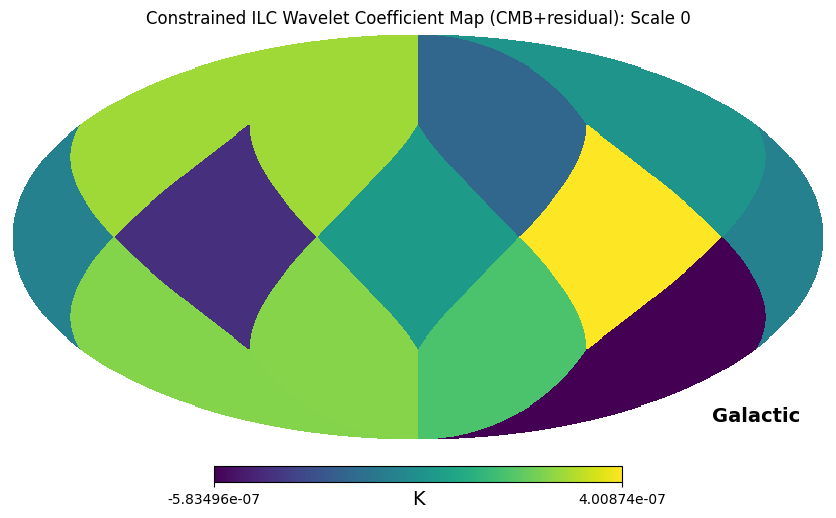

MW alm shape: (4, 7)


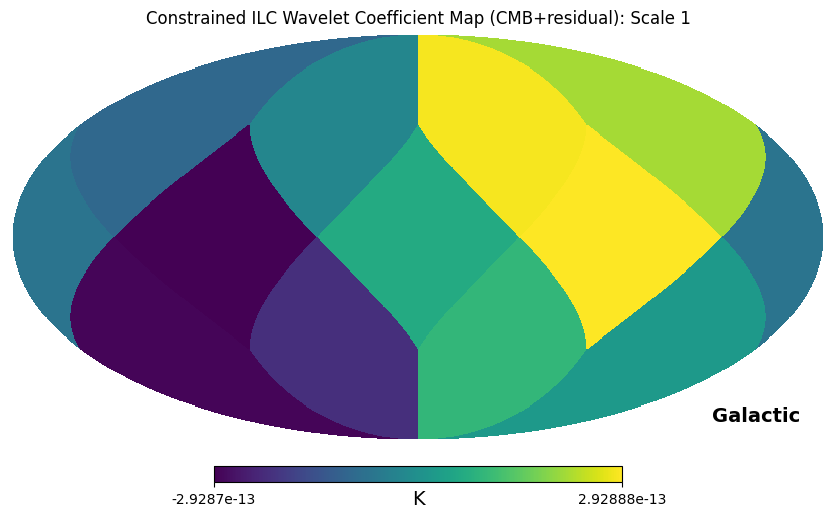

MW alm shape: (8, 15)


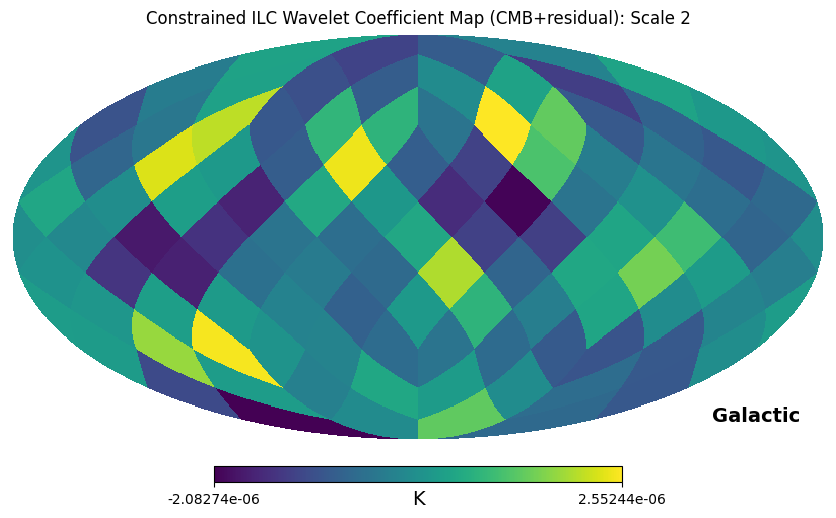

MW alm shape: (16, 31)


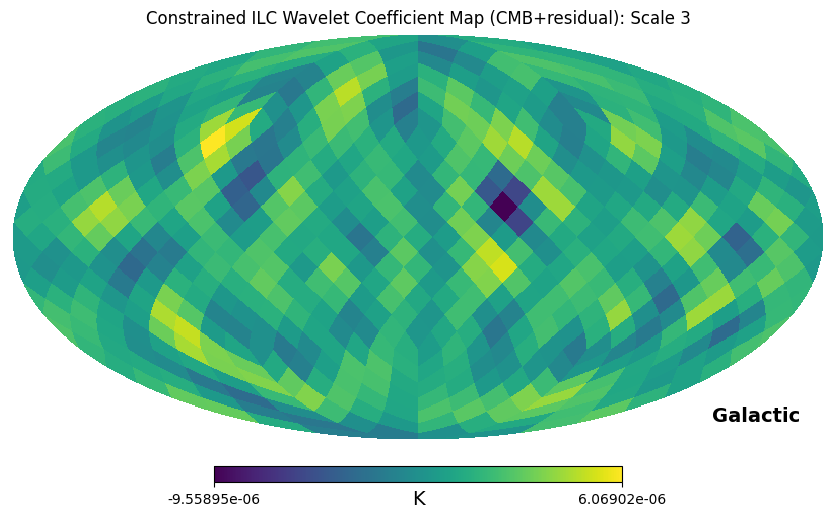

MW alm shape: (32, 63)


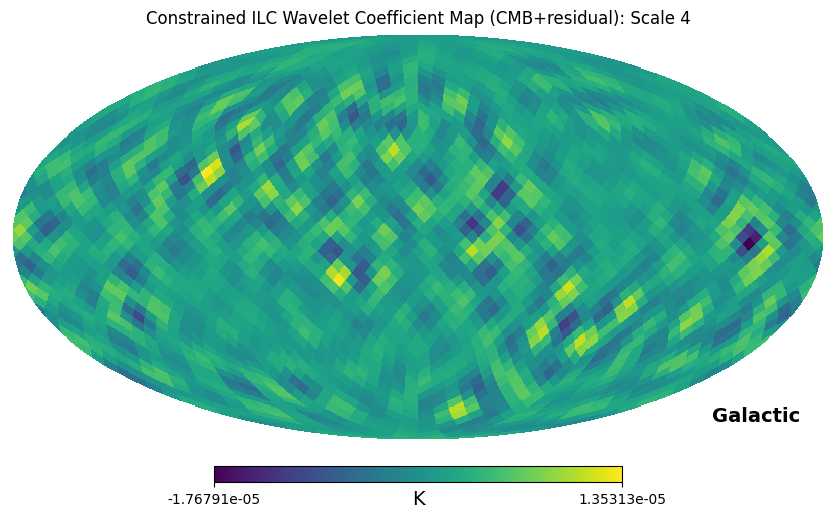

MW alm shape: (64, 127)


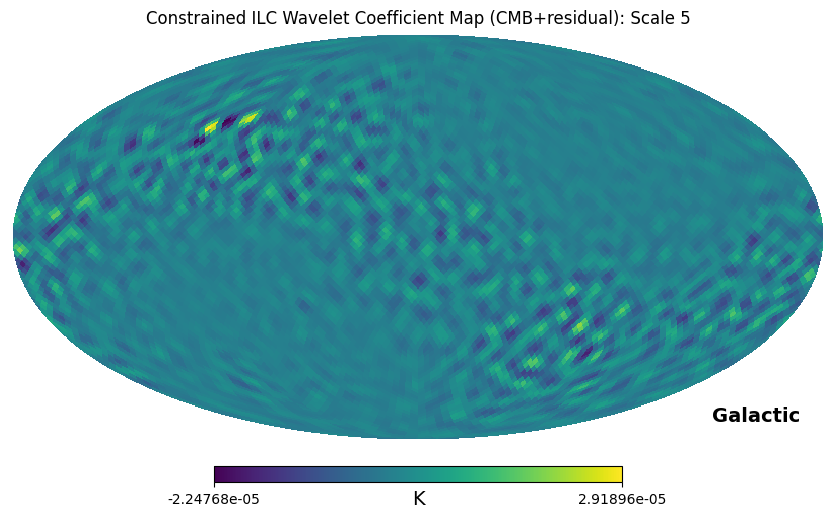

MW alm shape: (64, 127)


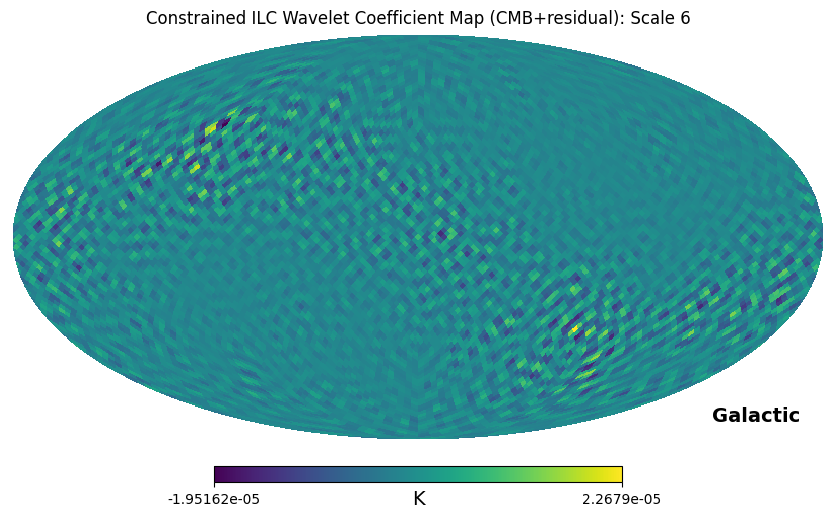

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


MW alm shape: (63, 125)


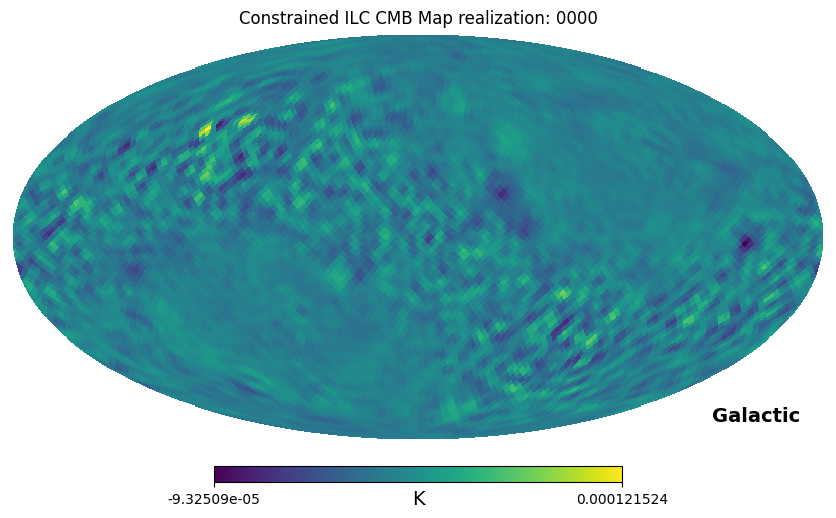

In [58]:
# Example usage (Constrained ILC)

#file_template = "wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{scale}_R{realization}.npy"

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
scales = [0, 1, 2, 3, 4, 5, 6]
realizations = range(1)

output_templates_constrained = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_{component}_constrained_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_{component}_constrained_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{component}_constrained_{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_{component}_constrained_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_{component}_constrained_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_constrained_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_constrained_F100_R{realization}.npy"
}

L_max = 63
N_directions = 1
a = np.ones(len(frequencies))

# Run constrained ILC to preserve CMB, null tSZ
l = ILC_wav_coeff_maps_MP_constrained(
    file_template,
    frequencies,
    scales,
    realizations,
    output_templates,
    L_max,
    N_directions,
    a,
    b,
    extract_tsz=False,       # False → preserve CMB, null tSZ
    component_name='cmb'
)

### 4.4 Visualize ILC combined Wavelet coefficient maps for each scale

MW alm shape: (4, 7)


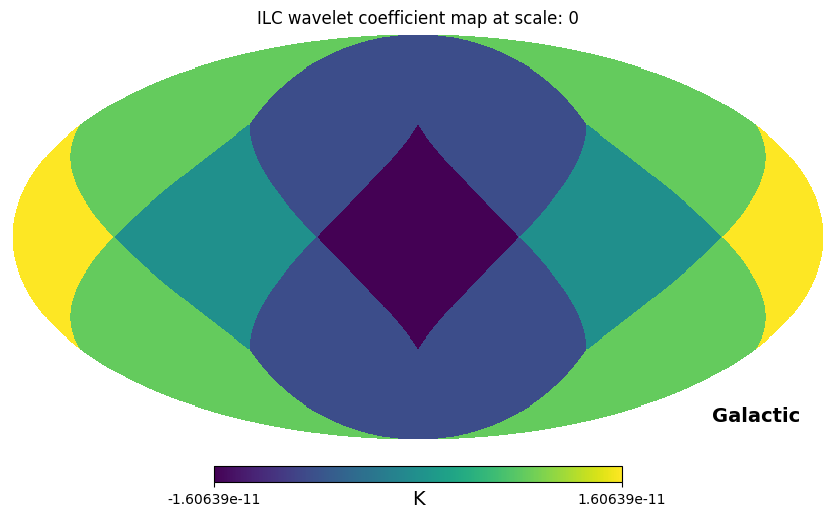

MW alm shape: (4, 7)


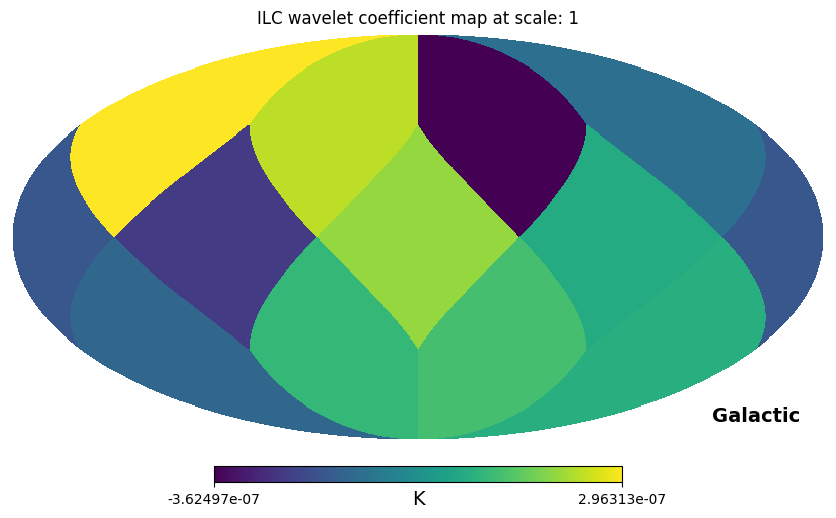

MW alm shape: (8, 15)


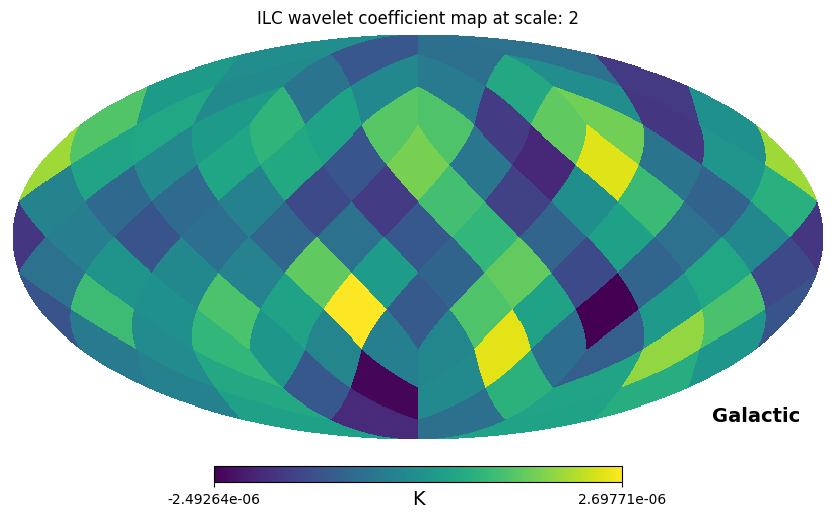

MW alm shape: (16, 31)


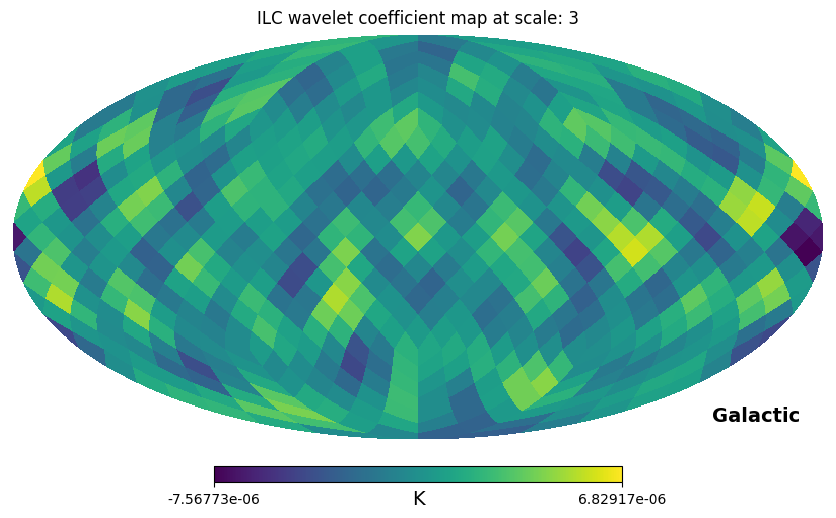

MW alm shape: (32, 63)


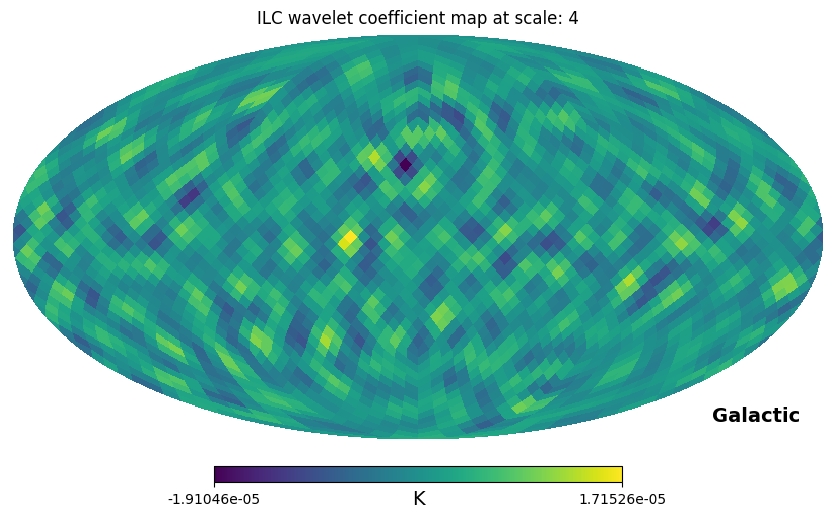

MW alm shape: (32, 63)


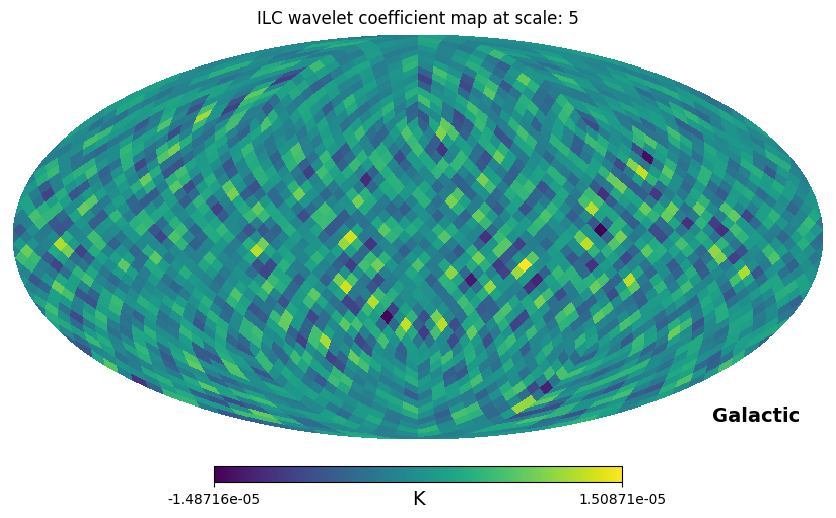

In [ ]:
L_max = 63
N_directions = 1
for r in range(1):
    realization = str(realizations[r]).zfill(4)
    trimmed_maps = [
    np.load(f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy")
    for scale in scales]

    for j in range(len(scales)):
        visualize_MW_Pix_map(trimmed_maps[j], "ILC wavelet coefficient map at scale: " + str(j))

### 4.5 Synthesize ILC wavelet coefficient maps of all scales together. (included in ILC_wav_coeff_maps_MP)

The output below is the synthesised ILC estimation of CMB signal for realization 0, and it could be used as a check point for ILC.

Note: Unfinished task for handling scaling coefficient.

MW alm shape: (63, 125)


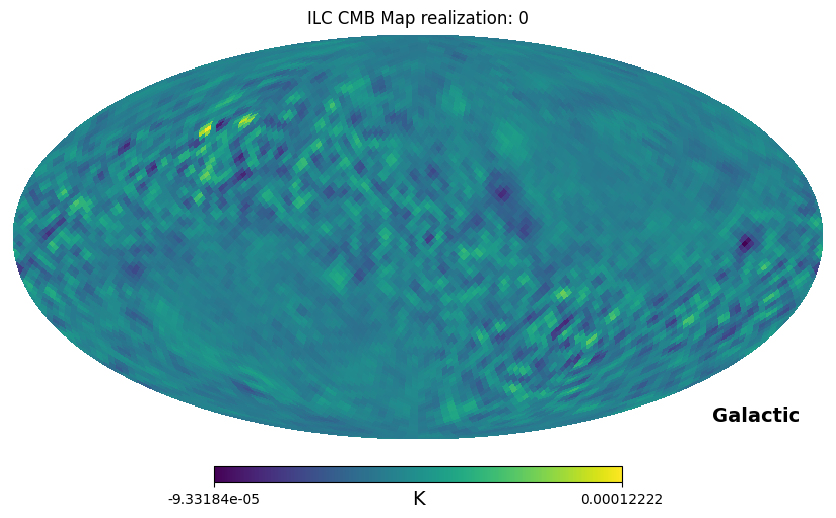

In [59]:
from s2wav import filters
import numpy as np
import s2wav
import s2fft
L_max = 63
N_directions = 1
scales = [0, 1, 2, 3, 4, 5, 6]
realizations = [0]
for i in range(len(realizations)):
    realization = str(realizations[i]).zfill(4)
    trimmed_maps = [np.load(f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy") for scale in range(len(scales))]

    filter = filters.filters_directional_vectorised(L_max, N_directions)
    # f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
    f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy") 

    # [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

    MW_Pix = s2wav.synthesis(trimmed_maps, L = L_max, f_scal = f_scal, filters = filter, N = 1)
    title = "ILC CMB Map realization: "
    visualize_MW_Pix_map(MW_Pix, title + str(realizations[i]))
    np.save(f"ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}", MW_Pix)

In [ ]:
# from s2wav import filters
# L_max = 32
# N_directions = 1
# for i in range(len(realizations)):
#     realization = str(realizations[i]).zfill(4)
#     trimmed_maps = [np.load(f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{i}_R{realization}.npy") for i in range(len(scales))]

#     filter = filters.filters_directional_vectorised(L_max, N_directions)
#     # f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
#     f_scal = np.array([[0]])    
#     # [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

#     MW_Pix = s2wav.synthesis(trimmed_maps, L = L_max, f_scal = f_scal, filters = filter, N = 1)
#     title = "ILC CMB Map realization: "
#     visualize_MW_Pix_map(MW_Pix, title, str(realizations[i]))
#     np.save(f"ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_0", MW_Pix)

### Generalized ILC Weight Calculation

### Step-by-Step Maths Verification 

In [60]:
import numpy as np

# Example spectral response vectors
a = np.ones(9)                   # CMB
b = np.linspace(-2, 2, 9)         # tSZ
c = np.linspace(1, 0, 9)          # Sync

# Build F in arbitrary order
F = np.column_stack([c, a, b])    # order changed: Sync, CMB, tSZ

# Store known spectral responses in a dict
reference_vectors = {
    "cmb": a,
    "tsz": b,
    "sync": c
}

def build_f(F, component_name):
    """Return constraint vector f for given component_name based on column match in F."""
    target_vec = reference_vectors[component_name.lower()]
    for col_idx in range(F.shape[1]):
        if np.allclose(F[:, col_idx] / np.linalg.norm(F[:, col_idx]),
                       target_vec / np.linalg.norm(target_vec)):
            f = np.zeros(F.shape[1])
            f[col_idx] = 1
            return f
    raise ValueError(f"Component '{component_name}' not found in F.")

# Test
print("F:\n", F)
print("f for cmb:", build_f(F, "cmb"))
print("f for tsz:", build_f(F, "tsz"))
print("f for sync:", build_f(F, "sync"))


F:
 [[ 1.     1.    -2.   ]
 [ 0.875  1.    -1.5  ]
 [ 0.75   1.    -1.   ]
 [ 0.625  1.    -0.5  ]
 [ 0.5    1.     0.   ]
 [ 0.375  1.     0.5  ]
 [ 0.25   1.     1.   ]
 [ 0.125  1.     1.5  ]
 [ 0.     1.     2.   ]]
f for cmb: [0. 1. 0.]
f for tsz: [0. 0. 1.]
f for sync: [1. 0. 0.]


In [61]:
import numpy as np

# Define simple integer inputs
R = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 3]
])  # Diagonal covariance matrix (3x3)

F = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [1, 1, 1]
])  # Spectral response matrix (3x3)

f = np.array([1, 0, 0])  # Constraint vector (3,)
f = f.reshape((F.shape[1], 1))
print ('f=', f)

# Step 1: Fᵗ R⁻¹
R_inv = np.linalg.inv(R)
FT_Rinv = np.dot(F.T, R_inv)
print("Step 1: Fᵗ R⁻¹ =\n", FT_Rinv)

# Step 2: Fᵗ R⁻¹ F
constraint_matrix = np.dot(FT_Rinv, F)
print("\nStep 2: Fᵗ R⁻¹ F =\n", constraint_matrix)

# Step 3: (Fᵗ R⁻¹ F)⁻¹
constraint_matrix_inv = np.linalg.inv(constraint_matrix)
print("\nStep 3: (Fᵗ R⁻¹ F)⁻¹ =\n", constraint_matrix_inv)

# Step 4: (Fᵗ R⁻¹ F)⁻¹ f
temp = np.dot(constraint_matrix_inv, f)
print("\nStep 4b: (Fᵗ R⁻¹ F)⁻¹ f =\n", temp)

# Step 5: F (Fᵗ R⁻¹ F)⁻¹ f
F_temp = np.dot(F, temp)
print("\nStep 5: F (Fᵗ R⁻¹ F)⁻¹ f =\n", F_temp)

# Step 6: Final weight vector
w = np.dot(R_inv, F_temp)
print("\nStep 6: Final weight vector w =\n", w)

# Step 7: Verify constraint Fᵗ w = f
FT_w = np.dot(F.T, w)
print("\nStep 7: Fᵗ w =\n", FT_w)
print("\nStep 7 check: Constraint satisfied (Fᵗ w = f_col) ?", np.allclose(FT_w, f))

import numpy as np

# Define integer-valued 4x4 covariance matrix (4 frequency channels)
R = np.array([
    [2, 0, 0, 0],
    [0, 3, 0, 0],
    [0, 0, 4, 0],
    [0, 0, 0, 5]
])  # (4x4)

# Define spectral response matrix: 4 freq channels × 2 components
F = np.array([
    [1, 0],    # Channel 1: only component 1
    [1, 1],    # Channel 2: mix of both
    [1, 2],    # Channel 3: stronger component 2
    [1, 3]     # Channel 4: even stronger component 2
])  # (4x2)

# Define constraint vector for extracting component 1
f = np.array([1, 0])  # We want to preserve only the first component
f = f.reshape((F.shape[1], 1))  # Reshape to (2,1)
print ('f=', f)

# Step 1: Fᵗ R⁻¹
R_inv = np.linalg.inv(R)
FT_Rinv = np.dot(F.T, R_inv)
print("Step 1: Fᵗ R⁻¹ =\n", FT_Rinv)

# Step 2: Fᵗ R⁻¹ F
constraint_matrix = np.dot(FT_Rinv, F)
print("\nStep 2: Fᵗ R⁻¹ F =\n", constraint_matrix)

# Step 3: (Fᵗ R⁻¹ F)⁻¹
constraint_matrix_inv = np.linalg.inv(constraint_matrix)
print("\nStep 3: (Fᵗ R⁻¹ F)⁻¹ =\n", constraint_matrix_inv)

# Step 4: (Fᵗ R⁻¹ F)⁻¹ f
temp = np.dot(constraint_matrix_inv, f)
print("\nStep 4: (Fᵗ R⁻¹ F)⁻¹ f =\n", temp)

# Step 5: F (Fᵗ R⁻¹ F)⁻¹ f
F_temp = np.dot(F, temp)
print("\nStep 5: F (Fᵗ R⁻¹ F)⁻¹ f =\n", F_temp)

# Step 6: Final weight vector
w = np.dot(R_inv, F_temp)
print("\nStep 6: Final weight vector w =\n", w)

# Step 7: Verify constraint Fᵗ w = f
FT_w = np.dot(F.T, w)
print("\nStep 7: Fᵗ w =\n", FT_w)
print("\nStep 7 check: Constraint satisfied (Fᵗ w = f_col) ?", np.allclose(FT_w, f))


f= [[1]
 [0]
 [0]]
Step 1: Fᵗ R⁻¹ =
 [[1.         0.5        0.33333333]
 [0.         0.5        0.33333333]
 [0.         0.         0.33333333]]

Step 2: Fᵗ R⁻¹ F =
 [[1.83333333 0.83333333 0.33333333]
 [0.83333333 0.83333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]

Step 3: (Fᵗ R⁻¹ F)⁻¹ =
 [[ 1.00000000e+00 -1.00000000e+00 -1.21115239e-16]
 [-1.00000000e+00  3.00000000e+00 -2.00000000e+00]
 [-2.01858732e-17 -2.00000000e+00  5.00000000e+00]]

Step 4b: (Fᵗ R⁻¹ F)⁻¹ f =
 [[ 1.00000000e+00]
 [-1.00000000e+00]
 [-2.01858732e-17]]

Step 5: F (Fᵗ R⁻¹ F)⁻¹ f =
 [[ 1.00000000e+00]
 [ 0.00000000e+00]
 [-2.01858732e-17]]

Step 6: Final weight vector w =
 [[ 1.00000000e+00]
 [ 0.00000000e+00]
 [-6.72862439e-18]]

Step 7: Fᵗ w =
 [[ 1.00000000e+00]
 [-6.72862439e-18]
 [-6.72862439e-18]]

Step 7 check: Constraint satisfied (Fᵗ w = f_col) ? True
f= [[1]
 [0]]
Step 1: Fᵗ R⁻¹ =
 [[0.5        0.33333333 0.25       0.2       ]
 [0.         0.33333333 0.5        0.6       ]]

Step 2: Fᵗ R⁻¹ F =


In [62]:
import numpy as np

# --- Physical constants ---
h = 6.62607015e-34       # Planck constant [J·s]
k = 1.380649e-23         # Boltzmann constant [J/K]
T_cmb = 2.7255           # CMB temperature [K]
c = 299792458            # Speed of light [m/s]

# --- Planck frequency channels in GHz ---
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
freqs_GHz = np.array([float(f) for f in frequencies])
nu = freqs_GHz * 1e9     # Convert GHz to Hz
x = h * nu / (k * T_cmb) # Dimensionless frequency

# --- Unit conversion factor from thermodynamic to brightness temp ---
g_nu = (x**2 * np.exp(x)) / (np.exp(x) - 1)**2

# --- (a) CMB: constant across frequencies in thermodynamic units ---
a = np.ones_like(nu)

# --- (b) tSZ: thermal SZ effect frequency dependence ---
fx = x * ((np.exp(x) + 1) / (np.exp(x) - 1)) - 4
# Zero out known nulls (no tSZ expected at these bands)
no_tsz_freqs = {'030', '044', '070'}
fx = np.array([fx[i] if frequencies[i] not in no_tsz_freqs else 0 for i in range(len(frequencies))])
# Normalize in thermodynamic units
b = fx / np.linalg.norm(fx)

# --- (c) Synchrotron: assume power law with β_s = -3.1 in brightness temp ---
beta_s = -3.1
nu0 = 30e9  # reference frequency (30 GHz)
T_sync_ant = (nu / nu0) ** beta_s
# Convert synchrotron to thermodynamic temp
T_sync_thermo = T_sync_ant / g_nu
# Normalize
c = T_sync_thermo / np.linalg.norm(T_sync_thermo)

# --- Output ---
print("a (CMB):", a)
print("b (tSZ):", b)
print("c (sync):", c)


a (CMB): [1. 1. 1. 1. 1. 1. 1. 1. 1.]
b (tSZ): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18225885e-01
 -8.15581790e-02 -6.09521620e-04  1.75660570e-01  4.38851414e-01
  8.69438516e-01]
c (sync): [0.86775717 0.27183924 0.06948647 0.02611258 0.01107374 0.00549842
 0.00524893 0.01690708 0.40880854]


In [63]:
import numpy as np
from s2wav import synthesis

# Store known spectral responses in a dict
# You must define these reference vectors before calling compute_weight_vector
reference_vectors = {
    "cmb": a,   # column 0 of F
    "tsz": b,   # column 1 of F
    "sync": c   # column 2 of F
}

def find_f_from_component_name(F, component_name):
    """Return constraint vector f for given component_name based on column match in F."""
    target_vec = reference_vectors[component_name.lower()]
    if target_vec is None:
        raise ValueError(f"Reference vector for '{component_name}' not set in reference_vectors.")

    for col_idx in range(F.shape[1]):
        if np.allclose(F[:, col_idx] / np.linalg.norm(F[:, col_idx]),
                       target_vec / np.linalg.norm(target_vec)):
            f = np.zeros(F.shape[1])
            f[col_idx] = 1
            return f, col_idx
    raise ValueError(f"Component '{component_name}' not found in F.")

def compute_weight_vector(R, scale, realization, weight_vector_matrix_template,
                          component, component_name,
                          constraint=False, F=None, f=None):
    """
    Computes weight vectors from a covariance matrix R using either standard or generalized ILC.

    Args:
        R (np.ndarray): Input covariance matrix. Shape (N_freq, N_freq) or (n1, n2, N_freq, N_freq).
        scale (int): Scale index for saving purposes.
        realization (str): Realization identifier string.
        weight_vector_matrix_template (str): Template for saving the computed weights.
        constraint (bool): Whether to use constrained ILC.
        F (np.ndarray): Spectral response matrix of shape (N_freq, N_comp), required if constraint=True.
        f (np.ndarray): Constraint vector of shape (N_comp,), required if constraint=True.

    Returns:
        inverses (np.ndarray): Inverse covariance matrices.
        weight_vectors (np.ndarray): Weight vectors.
        singular_matrices_location (list): List of (i, j) indices where matrix inversion failed.
    """
    if R.ndim == 4:
        R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3)
        dim1, dim2 = R_Pix.shape[:2]
        subdim1, subdim2 = R_Pix.shape[2:]
    elif R.ndim == 2:
        R_Pix = R
        dim1, dim2 = 1, 1
        subdim1, subdim2 = R_Pix.shape
    else:
        raise ValueError(f"Unexpected array dimension: {R.ndim}")

    if constraint:
        N_freq, N_comp = F.shape
        print("DEBUG in compute_weight_vector:")
        print("component_name:", component_name)
        print("f vector:", f)
        print("F shape in compute_weight_vector:", F.shape)

        # --- Automatically set f from component_name if given ---
        if f is None and component_name is not None:
            f, _ = find_f_from_component_name(F, component_name)
        # -------------------------------------------------------------
        assert f is not None, "Constraint vector f must be provided when constraint=True"
        assert f.shape == (N_comp,), f"Constraint vector f must have shape ({N_comp},)"
    else:
        # --- Use component_name also for unconstrained ILC ---
        if component_name is None:
            raise ValueError("component_name must be provided when constraint=False")
        _, component_index = find_f_from_component_name(F, component_name)
        N_freq = subdim2
        identity_vector = np.zeros(N_freq)
        identity_vector[component_index] = 1.0
        # ----------------------------------------------------------

    inverses = np.zeros((dim1, dim2, subdim1, subdim2)) if R.ndim == 4 else np.zeros((subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) if R.ndim == 4 else np.zeros(subdim1)
    singular_matrices_location = []

    for i in range(dim1):
        for j in range(dim2):
            try:
                R_inv = np.linalg.inv(R_Pix[i, j] if R.ndim == 4 else R_Pix)

                if constraint:
                    # Step 1: Fᵗ R⁻¹
                    FT_Rinv = np.dot(F.T, R_inv)                  # (N_comp, N_freq)
                    # Step 2: Fᵗ R⁻¹ F
                    constraint_matrix = np.dot(FT_Rinv, F)        # (N_comp, N_comp)
                    # Step 3: (Fᵗ R⁻¹ F)⁻¹
                    constraint_matrix_inv = np.linalg.inv(constraint_matrix)

                    # Step 4: reshape f for matrix multiplication
                    f_vec = f.reshape((F.shape[1], 1))  # [1,0,0] -----> [[1],
                                                        #                 [0],
                                                        #                 [0]]
                    temp = np.dot(constraint_matrix_inv, f_vec)
                    # Step 5: F (Fᵗ R⁻¹ F)⁻¹ f
                    F_temp = np.dot(F, temp)
                    # Step 6: Final weight vector
                    w = np.dot(R_inv, F_temp).T
                else:
                    numerator = np.dot(R_inv, identity_vector)
                    denominator = np.dot(numerator, identity_vector)
                    w = numerator / denominator

                if R.ndim == 4:
                    inverses[i, j] = R_inv
                    weight_vectors[i, j] = w
                else:
                    inverses = R_inv
                    weight_vectors = w

            except np.linalg.LinAlgError:
                singular_matrices_location.append((i, j))
                singular_matrix_path = weight_vector_matrix_template.format(
                    component=component,
                    component_name=component_name,
                    scale=scale,
                    realization=realization
                ).replace(".npy", f"_singular_{i}_{j}.npy")
                np.save(singular_matrix_path, R_Pix[i, j] if R.ndim == 4 else R_Pix)
                if R.ndim == 4:
                    weight_vectors[i, j] = np.zeros(N_freq)
                else:
                    weight_vectors = np.zeros(N_freq)

    # Save final weight vector matrix
    np.save(
        weight_vector_matrix_template.format(
            component=component,
            component_name=component_name,
            scale=scale,
            realization=realization
        ),
        weight_vectors
    )

    return inverses, weight_vectors, singular_matrices_location, component_name


In [64]:
def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[i, j], pix_vector)

def create_doubled_ILC_map(frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization, constraint=False, component=None, component_name=None):
    size = doubled_MW_wav_c_j[(frequencies[0], scale)].shape
    doubled_map = np.zeros((size[0], size[1]))

    for i in range(doubled_map.shape[0]):
        for j in range(doubled_map.shape[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j)

    if constraint:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy"
    else:
        path = f"ILC/ILC_doubled_maps/ILC_Map_{component}_S{scale}_R{realization}_MP.npy"

    np.save(path, doubled_map)
    return doubled_map

def synthesize_ILC_maps_generalised(
    trimmed_maps, realization, output_templates,
    L_max, N_directions,
    component=None, component_name=None, constraint=None):

    """
    Synthesizes full-sky ILC or cILC map from trimmed wavelet coefficient maps.

    Args:
        trimmed_maps (list): Trimmed wavelet maps across scales.
        realization (str): Realization string (e.g., '0000').
        output_templates (dict): Output file templates.
        L_max (int): Maximum spherical harmonic degree.
        N_directions (int): Number of wavelet directions.
        component_name (str or None): Component name for constrained ILC (e.g., 'cmb').

    Returns:
        np.ndarray: Final synthesized ILC map.
    """
    f_scal = np.load(output_templates['f_scal'].format(
    component=component,
    realization=realization))

    filter_bank = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix = synthesis(trimmed_maps, L=L_max, f_scal=f_scal, filters=filter_bank, N=N_directions)

    # Title and filename
    prefix = "cILC" if component_name else "ILC"
    name = component_name.upper() if component_name else ""
    title = f"{prefix} {name} Map | realization: {realization}".strip()

    # Minimal fix: format filename with component and component_name
    filename = output_templates['synthesized_maps'].format(
        component=component,
        component_name=component_name,
        realization=realization
    )

    visualize_MW_Pix_map(MW_Pix, title)
    np.save(filename, MW_Pix)
    return MW_Pix

In [65]:
def ILC_wav_coeff_maps_MP(
    file_template, frequencies, scales, realizations,
    output_templates, L_max, N_directions,
    component,
    constraint=False, F=None, component_name=None):
    """
    Computes ILC or constrained ILC (cILC) wavelet coefficient maps.
    """
    import concurrent.futures
    import numpy as np

    synthesized_maps = []

    # Prepare constraint vector if needed
    f = None
    if constraint:
        if F is None or component_name is None:
            raise ValueError("Must provide F and component_name if constraint=True")
        component_index = {name: i for i, name in enumerate(['cmb', 'tsz', 'sync'])}[component_name]
        f = np.zeros(F.shape[1])
        f[component_index] = 1.0

    for realization in realizations:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str} for component {component}")

        # 1️⃣ Load original wavelet maps
        original_wavelet_c_j = load_frequency_data(
            file_template, frequencies, scales, realization_str, component
        )

        # 2️⃣ Double resolution and save
        double_and_save_wavelet_maps_MP(
            original_wavelet_c_j, frequencies, scales, realization_str,
            component, output_templates['doubled_maps']
        )

        # 3️⃣ Load doubled resolution wavelet maps
        doubled_MW_wav_c_j = load_frequency_data(
            output_templates['doubled_maps'], frequencies, scales, realization_str, component
        )

        # 4️⃣ Compute covariance matrices
        with concurrent.futures.ProcessPoolExecutor() as executor:
            covariance_tasks = [
                executor.submit(
                    calculate_covariance_matrix_MP,
                    frequencies, doubled_MW_wav_c_j, scale,
                    realization_str, component,
                    output_templates['covariance_matrices']
                )
                for scale in scales
            ]
            for future in concurrent.futures.as_completed(covariance_tasks):
                future.result()

        # 5️⃣ Load covariance matrices
        F_str = '_'.join(frequencies)
        R_covariance = [
            np.load(output_templates['covariance_matrices'].format(
                component=component, frequencies=F_str,
                scale=scale, realization=realization_str
            ))
            for scale in scales
        ]

        # 6️⃣ Compute weight vectors
        weight_vector_load = []
        for scale_idx, scale in enumerate(scales):
            if constraint:
                compute_weight_vector(
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'],
                    component=component, component_name=component_name,
                    constraint=True, F=F, f=f
                )
                name = f"cilc_{component_name}"
            else:
                compute_weight_vector(
                    R_covariance[scale_idx], scale, realization_str,
                    output_templates['weight_vector_matrices'],
                    component=component, component_name=component_name,
                    constraint=False, component_index=0
                )
                name = "weight_vector"

            weight_vector_path = output_templates['weight_vector_matrices'].format(
                component=component,
                component_name=component_name,
                type=name,
                scale=scale,
                realization=realization_str
            )
            weight_vector_load.append(np.load(weight_vector_path))

        # 7️⃣ Create and save doubled ILC maps
        doubled_maps = []
        for i, scale in enumerate(scales):
            map_ = create_doubled_ILC_map(
                frequencies, scale, weight_vector_load[i], doubled_MW_wav_c_j,
                realization_str, component=component,
                constraint=constraint, component_name=component_name
            )
            doubled_maps.append(map_)
            np.save(output_templates['ilc_maps'].format(
                component=component,
                component_name=component_name,
                scale=scale,
                realization=realization_str
            ), map_)

        # 8️⃣ Trim maps to original resolution
        trimmed_maps = [
            trim_to_original(
                doubled_maps[i], scales[i], realization_str,
                component=component,
                component_name=component_name,
                path_template=output_templates['trimmed_maps']
            )
            for i in range(len(scales))
        ]

        # 9️⃣ Synthesize final map
        synthesized_map = synthesize_ILC_maps_generalised(
            trimmed_maps, realization_str, output_templates, L_max, N_directions,
            component_name=component_name, component=component, constraint=constraint
        )
        synthesized_maps.append(synthesized_map)
    print("DEBUG: F in ILC_wav_coeff_maps_MP:")
    print("Shape:", F.shape)
    print(F)


    return synthesized_maps


In [66]:
import numpy as np

# --- Physical constants ---
h = 6.62607015e-34       # Planck constant [J·s]
k = 1.380649e-23         # Boltzmann constant [J/K]
T_cmb = 2.7255           # CMB temperature [K]
c = 299792458            # Speed of light [m/s]

# --- Planck frequency channels in GHz ---
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
freqs_GHz = np.array([float(f) for f in frequencies])
nu = freqs_GHz * 1e9     # Convert GHz to Hz
x = h * nu / (k * T_cmb) # Dimensionless frequency

# --- Unit conversion factor from thermodynamic to brightness temp ---
g_nu = (x**2 * np.exp(x)) / (np.exp(x) - 1)**2

# --- (a) CMB: constant across frequencies in thermodynamic units ---
a = np.ones_like(nu)/ np.linalg.norm(np.ones_like(nu))

# --- (b) tSZ: thermal SZ effect frequency dependence ---
fx = x * ((np.exp(x) + 1) / (np.exp(x) - 1)) - 4
# Zero out known nulls (no tSZ expected at these bands)
no_tsz_freqs = {'030', '044', '070'}
fx = np.array([fx[i] if frequencies[i] not in no_tsz_freqs else 0 for i in range(len(frequencies))])
# Normalize in thermodynamic units
b = fx / np.linalg.norm(fx)

# --- (c) Synchrotron: assume power law with β_s = -3.1 in brightness temp ---
beta_s = -3.1
nu0 = 30e9  # reference frequency (30 GHz)
T_sync_ant = (nu / nu0) ** beta_s
# Convert synchrotron to thermodynamic temp
T_sync_thermo = T_sync_ant / g_nu
# Normalize
c = T_sync_thermo / np.linalg.norm(T_sync_thermo)

# --- Output ---
print("a (CMB):", a)
print("b (tSZ):", b)
print("c (sync):", c)

a (CMB): [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333]
b (tSZ): [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18225885e-01
 -8.15581790e-02 -6.09521620e-04  1.75660570e-01  4.38851414e-01
  8.69438516e-01]
c (sync): [0.86775717 0.27183924 0.06948647 0.02611258 0.01107374 0.00549842
 0.00524893 0.01690708 0.40880854]


In [67]:
import numpy as np

components = {
    'CMB': a,
    'tSZ': b,
    'sync': c,
}

F = np.stack([a, b, c], axis=1)  # F is (N_freq, N_comp)
print('F:', F)

def get_constraint_vector(F, name, components):
    target_vec = components[name]
    for i in range(F.shape[1]):
        if np.allclose(F[:, i], target_vec):
            f = np.zeros(F.shape[1])
            f[i] = 1.0
            print(f"Component '{name}' matched at column {i}")
            return f
    raise ValueError(f"Component vector for '{name}' not found in F.")

f = get_constraint_vector(F, 'CMB', components)
print ('f:',f)

F: [[ 3.33333333e-01  0.00000000e+00  8.67757169e-01]
 [ 3.33333333e-01  0.00000000e+00  2.71839240e-01]
 [ 3.33333333e-01  0.00000000e+00  6.94864702e-02]
 [ 3.33333333e-01 -1.18225885e-01  2.61125772e-02]
 [ 3.33333333e-01 -8.15581790e-02  1.10737419e-02]
 [ 3.33333333e-01 -6.09521620e-04  5.49841744e-03]
 [ 3.33333333e-01  1.75660570e-01  5.24893397e-03]
 [ 3.33333333e-01  4.38851414e-01  1.69070773e-02]
 [ 3.33333333e-01  8.69438516e-01  4.08808544e-01]]
Component 'CMB' matched at column 0
f: [1. 0. 0.]


In [ ]:
import numpy as np

# Frequency names
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']

# Wavelet scales
scales = [0, 1, 2, 3, 4, 5, 6]  

# Realization list
realizations = [0]

# Whether you're running constrained or unconstrained ILC
constraint = True  # change this to False for unconstrained run

# Define both output_templates versions
output_templates = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

output_templates_CONSTRAINT = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_{component}_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_{component}_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_cilc_{component_name}_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R{realization}.npy"
}


# Select appropriate output template based on constraint flag
templates = output_templates_CONSTRAINT if constraint else output_templates

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

realizations = ["0000"]  # string

for realization in realizations:
    print(f"Processing realization {realization}")

    constrained_maps = ILC_wav_coeff_maps_MP(
        file_template=file_template,
        frequencies=frequencies,
        scales=scales,
        realizations=[realization],  # string
        output_templates=templates,
        L_max=L_max,
        N_directions=N_directions,
        constraint=True,
        F=F,
        component='CSNT',
        component_name='cmb'
    )

Processing realization 0000
Processing realization 0000 for component CSNT


In [ ]:
import numpy as np

# Frequency names
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']

# Wavelet scales
scales = [0, 1, 2, 3, 4, 5]  

# Realization list
realizations = [0]

# Whether you're running constrained or unconstrained ILC
constraint = True  # change this to False for unconstrained run

# Define both output_templates versions
output_templates = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{type}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F100_R{realization}.npy"
}

output_templates_CONSTRAINT = {
    'doubled_maps': "ILC/wavelet_doubled/Wav_Pix2_{component}_F{frequency}_S{scale}_R{realization}_MP.npy",
    'covariance_matrices': "ILC/covariance_matrix/cov_MW_Pix2_{component}_F{frequencies}_S{scale}_R{realization}_MP.npy",
    'weight_vector_matrices': "ILC/weight_vector_data/{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'ilc_maps': "ILC/ILC_doubled_maps/ILC_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'trimmed_maps': "ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_{component}_cilc_{component_name}_S{scale}_R{realization}_MP.npy",
    'synthesized_maps': "ILC/synthesized_ILC_MW_maps/{component}_ILC_MW_Map_cilc_{component_name}_R{realization}_MP.npy",
    'f_scal': "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R{realization}.npy"
}


# Select appropriate output template based on constraint flag
templates = output_templates_CONSTRAINT if constraint else output_templates

file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization}.npy"
)

realizations = ["0000"]  

for realization in realizations:
    print(f"Processing realization {realization}")

    constrained_maps = ILC_wav_coeff_maps_MP(
        file_template=file_template,
        frequencies=frequencies,
        scales=scales,
        realizations=[realization], 
        output_templates=templates,
        L_max=63,
        N_directions=N_directions,
        constraint=True,
        F=F,
        component='CSNT',
        component_name='cmb'
    )

Processing realization 0000
Processing realization 0000 for component CSNT
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)
DEBUG in compute_weight_vector:
component_name: cmb
f vector: [1. 0. 0.]
F shape in compute_weight_vector: (9, 3)


ValueError: Incompatible shapes for broadcasting: (1, 32, 63) and requested shape (1, 63, 125)

In [ ]:
def assert_is_MW_pix(arr):
    """
    Assert that an array has MW pixel shape:
    - 2D: (L, 2L-1)
    - 3D: (Ndir, L, 2L-1)
    """
    shape = arr.shape
    if len(shape) == 2:
        L = shape[0]
        assert shape[1] == 2*L - 1, f"Not MW shape: {shape}"
    elif len(shape) == 3:
        L = shape[1]
        assert shape[2] == 2*L - 1, f"Not MW shape: {shape}"
    else:
        raise AssertionError(f"Unexpected rank for MW map: {shape}")

# Example: load your final product and test
import numpy as np

path = output_templates['synthesized_maps'].format(realization="0000")  # adjust realization
final_map = np.load(path)

assert_is_MW_pix(final_map)
print("✅ Final product is MW pixel format:", final_map.shape)


✅ Final product is MW pixel format: (32, 63)


In [ ]:
def assert_is_MW_pix(arr):
    # MW pixel maps are typically (L, 2L-1) or (Ndir, L, 2L-1)
    shape = arr.shape
    if len(shape) == 2:
        L = shape[0]
        assert shape[1] == 2*L - 1, f"Not MW shape: {shape}"
    elif len(shape) == 3:
        L = shape[1]
        assert shape[2] == 2*L - 1, f"Not MW shape: {shape}"
    else:
        raise AssertionError(f"Unexpected rank for MW map: {shape}")

def assert_is_MW_alm(arr):
    # MW alm are (L, 2L-1)
    L = arr.shape[0]
    assert arr.shape[1] == 2*L - 1, f"Not MW alm shape: {arr.shape}"


In [ ]:
# --- DEBUG PREVIEW: What are F and f for this run? ---
np.set_printoptions(precision=6, suppress=True)  # nicer formatting
print("F shape:", F.shape)
print("F:\n", F)  # full matrix

# Label each column of F using your reference_vectors
def label_F_columns(F, refs):
    for j in range(F.shape[1]):
        col = F[:, j] / np.linalg.norm(F[:, j])
        best_name, best_val = None, -np.inf
        for name, vec in refs.items():
            if vec is None: 
                continue
            nvec = vec / np.linalg.norm(vec)
            sim = np.dot(col, nvec)  # cosine similarity
            if sim > best_val:
                best_val, best_name = sim, name
        print(f"Column {j} looks like: {best_name} (cosine={best_val:.6f})")

# Make sure you set these somewhere earlier:
# reference_vectors = {"cmb": a, "tsz": b, "sync": c}
label_F_columns(F, reference_vectors)

# Build the constraint vector f the same way compute_weight_vector will
f_dbg, col_idx = find_f_from_component_name(F, "cmb")   # or "tsz"/"sync"
print("f (for component_name='cmb'):", f_dbg, "  matched column:", col_idx)
print("-" * 60)


F shape: (9, 3)
F:
 [[ 0.333333  0.        0.867757]
 [ 0.333333  0.        0.271839]
 [ 0.333333  0.        0.069486]
 [ 0.333333 -0.118226  0.026113]
 [ 0.333333 -0.081558  0.011074]
 [ 0.333333 -0.00061   0.005498]
 [ 0.333333  0.175661  0.005249]
 [ 0.333333  0.438851  0.016907]
 [ 0.333333  0.869439  0.408809]]
Column 0 looks like: cmb (cosine=1.000000)
Column 1 looks like: tsz (cosine=1.000000)
Column 2 looks like: sync (cosine=1.000000)
f (for component_name='cmb'): [1. 0. 0.]   matched column: 0
------------------------------------------------------------


In [ ]:
# Make sure these are the ones you actually use everywhere:
reference_vectors = {"cmb": np.array(a), "tsz": np.array(b), "sync": np.array(c)}

# 1) Hard equality checks (should be True)
print("a==F[:,0] ?", np.allclose(F[:,0], reference_vectors["cmb"]))
print("b==F[:,1] ?", np.allclose(F[:,1], reference_vectors["tsz"]))
print("c==F[:,2] ?", np.allclose(F[:,2], reference_vectors["sync"]))

# 2) Cosine checks (should be ~1.0)
def cosine(u,v):
    u = np.asarray(u); v = np.asarray(v)
    return float(np.dot(u/np.linalg.norm(u), v/np.linalg.norm(v)))

print("cos(F[:,0],a) =", cosine(F[:,0], reference_vectors["cmb"]))
print("cos(F[:,1],b) =", cosine(F[:,1], reference_vectors["tsz"]))
print("cos(F[:,2],c) =", cosine(F[:,2], reference_vectors["sync"]))


a==F[:,0] ? True
b==F[:,1] ? True
c==F[:,2] ? True
cos(F[:,0],a) = 1.0000000000000002
cos(F[:,1],b) = 1.0
cos(F[:,2],c) = 0.9999999999999996


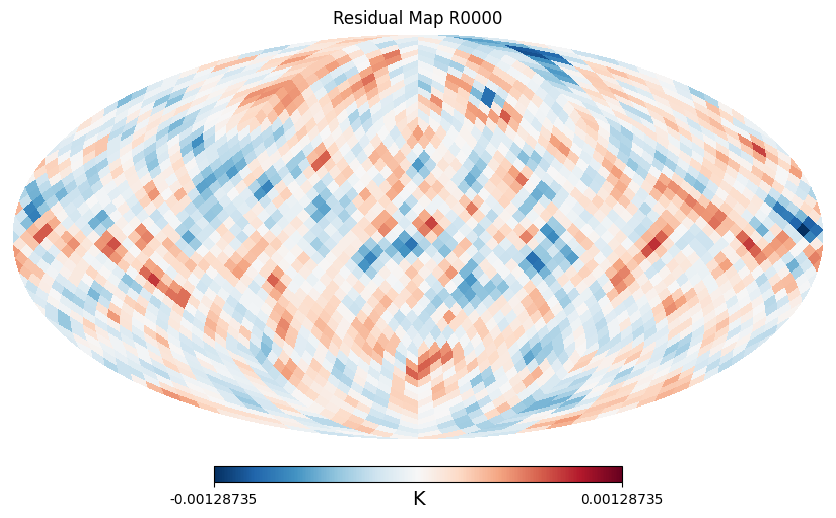

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

component_name = "cmb"
realizations = [0]

for realization in realizations:
    realization_str = f"{realization:04d}"

    # Paths for synthesized MW maps
    cmb_path  = f"ILC/synthesized_ILC_MW_maps/ILC_MW_Map_cilc_{component_name}_R{realization_str}_MP.npy"
    csnt_path = f"ILC/synthesized_ILC_MW_maps/CSNT_ILC_MW_Map_cilc_{component_name}_R{realization_str}_MP.npy"

    # Load synthesized maps
    ilc_cmb  = np.load(cmb_path)
    ilc_csnt = np.load(csnt_path)

    # Compute residual in MW pixel space
    residual_mw = ilc_csnt - ilc_cmb

    # Ensure residual folder exists before saving
    residual_dir = "ILC/residuals"
    os.makedirs(residual_dir, exist_ok=True)

    np.save(os.path.join(residual_dir, f"Residual_MW_R{realization_str}.npy"), residual_mw)

    # Convert residual map to Healpix
    L_max = residual_mw.shape[0]
    mw_alm = s2fft.forward(residual_mw, L=L_max)           # MW → ALM
    hp_alm = mw_alm_2_hp_alm(mw_alm, L_max-1)              # ALM MW → ALM Healpix
    nside = (L_max - 1) // 2                               # Healpix NSIDE
    residual_hp = hp.alm2map(hp_alm, nside=nside, verbose=False)

    # Visualize residual map
    vmax = np.max(np.abs(residual_hp))                     # Symmetric color range
    hp.mollview(
        residual_hp,
        title=f"Residual Map R{realization_str}",
        unit='K',
        cmap='RdBu_r',
        min=-vmax,
        max=vmax
    )
    plt.show()


✅ Spectral Response Matrix F:
[[ 1.       -1.953721  1.      ]
 [ 1.       -1.900973  0.316961]
 [ 1.       -1.753052  0.078717]
 [ 1.       -1.508262  0.027   ]
 [ 1.       -1.040666  0.009233]
 [ 1.       -0.008348  0.002642]
 [ 1.        2.239693  0.000614]
 [ 1.        5.596377  0.000167]
 [ 1.       11.088037  0.000043]]

🔍 Linear Independence Check:
→ Rank of F: 3
→ Condition number of F: 15.49221201509465
→ Singular values: [13.186534  2.939446  0.851172]


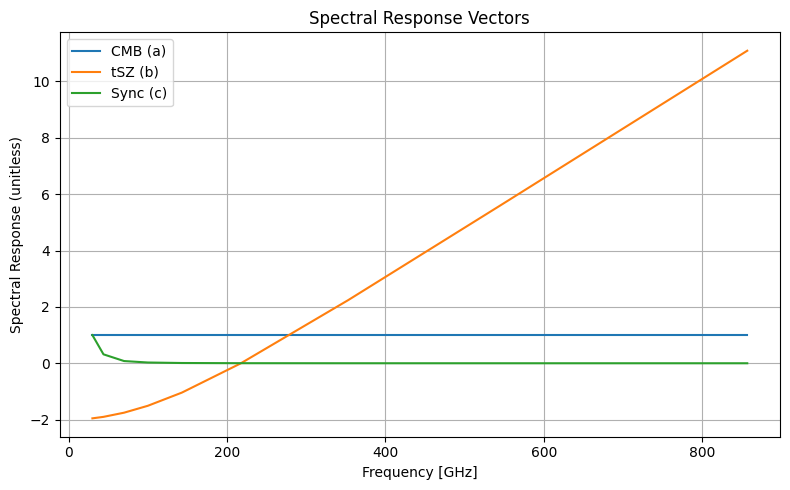


🧪 Pixel-wise linear mixing check at pixel: 100

Frequency 030 GHz:
  CMB: -0.00011941978300455958
  Sync: 2.691045665415004e-05
  Noise: 1.570331005495973e-05
  tSZ: 0.0
  → Predicted Total Map Value: -7.680601629544981e-05

Frequency 044 GHz:
  CMB: -0.00011944855941692367
  Sync: 7.348020972131053e-06
  Noise: 1.423824687663e-05
  tSZ: 0.0
  → Predicted Total Map Value: -0.00010288127696732763

Frequency 070 GHz:
  CMB: -0.00011947339226026088
  Sync: 1.998879952225252e-06
  Noise: 1.4347884643939324e-05
  tSZ: 0.0
  → Predicted Total Map Value: -0.0001049681613810152

Frequency 100 GHz:
  CMB: -0.00011951132182730362
  Sync: 7.507661052841286e-07
  Noise: -2.1379980807978427e-07
  tSZ: -3.4131801385228755e-06
  → Predicted Total Map Value: -0.00011455688082914562

Frequency 143 GHz:
  CMB: -0.00011957490642089397
  Sync: 3.454522072843247e-07
  Noise: 6.732610700055375e-07
  tSZ: 0.6336766481399536
  → Predicted Total Map Value: -0.6595643391015037

Frequency 217 GHz:
  CMB: -0.000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

# --- Configuration ---
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
frequencies_float = np.array([float(f) for f in frequencies])
components = ["CMB", "Sync", "Noise", "tSZ"]
realization = 0
desired_lmax = 63
pix_check = 100  # arbitrary pixel index to test the spectral mixing

# --- Define Spectral Response Vectors ---
a = np.ones(len(frequencies))  # CMB: flat in thermodynamic units

# tSZ: x = hν / kT_cmb ≈ ν / 56.8 GHz
x = frequencies_float / 56.8
b = x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4  # tSZ thermal distortion shape

# Synchrotron: power-law with spectral index β ≈ -3.0
beta_sync = -3.0
c = (frequencies_float / 30.0)**beta_sync

# Stack into F
F = np.column_stack([a, b, c])
print("✅ Spectral Response Matrix F:")
print(F)

# --- Linear Independence Check ---
rank = np.linalg.matrix_rank(F)
cond = np.linalg.cond(F)
U, S, Vt = np.linalg.svd(F)

print("\n🔍 Linear Independence Check:")
print("→ Rank of F:", rank)
print("→ Condition number of F:", cond)
print("→ Singular values:", S)

# --- Plot Spectral Responses ---
plt.figure(figsize=(8, 5))
plt.plot(frequencies_float, a, label="CMB (a)")
plt.plot(frequencies_float, b, label="tSZ (b)")
plt.plot(frequencies_float, c, label="Sync (c)")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Spectral Response (unitless)")
plt.title("Spectral Response Vectors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Confirm Mixing at One Pixel (Optional Sanity Check) ---
print("\n🧪 Pixel-wise linear mixing check at pixel:", pix_check)

# Load component maps at each frequency
for freq in frequencies:
    map_values = {}
    for comp in components:
        map_path = f"CMB_total/{comp}_HP_Map_F{freq}_L{desired_lmax}_R{realization:04d}.fits"
        if os.path.exists(map_path):
            data = hp.read_map(map_path, verbose=False)
            map_values[comp] = data[pix_check]
        else:
            map_values[comp] = np.nan

    print(f"\nFrequency {freq} GHz:")
    for comp in components:
        print(f"  {comp}: {map_values[comp]}")

    # Linear prediction of total
    i = frequencies.index(freq)
    pred_total = (
        a[i] * map_values["CMB"] +
        b[i] * map_values["tSZ"] +
        c[i] * map_values["Sync"] +
        map_values["Noise"]
    )
    print(f"  → Predicted Total Map Value: {pred_total}")


In [ ]:
import numpy as np

# Define spectral response vectors
frequencies = np.array([30, 44, 70, 100, 143, 217, 353, 545, 857])
a = np.ones_like(frequencies, dtype=float)  # CMB
x = frequencies / 56.8
b = x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4  # tSZ
beta_sync = -3.0
c = (frequencies / 30.0) ** beta_sync  # synchrotron

# Stack into F matrix (shape: n_freq x 3)
F = np.column_stack([a, b, c])
component_index = 0  # 0 = CMB

# Simulate a covariance matrix (here using identity for simplicity — replace with your real C)
n_freq = len(frequencies)
C = np.identity(n_freq)

# --- Compute the constrained ILC weights ---
invC = np.linalg.pinv(C)
e = np.zeros(F.shape[1])
e[component_index] = 1  # e = [1, 0, 0] → preserve CMB

w = invC @ F @ np.linalg.inv(F.T @ invC @ F) @ e

# --- Check constraints ---
dot_wa = np.dot(w, a)
dot_wb = np.dot(w, b)
dot_wc = np.dot(w, c)

print("w^T a (should be 1):", dot_wa)
print("w^T b (should be 0):", dot_wb)
print("w^T c (should be 0):", dot_wc)

print("All constraints satisfied?",
      np.isclose(dot_wa, 1) and np.isclose(dot_wb, 0) and np.isclose(dot_wc, 0))

# Optional: print weights
print("\nWeights per frequency:", w)


w^T a (should be 1): 0.9999999999999998
w^T b (should be 0): -4.85722573273506e-16
w^T c (should be 0): -3.0175336987697636e-17
All constraints satisfied? True

Weights per frequency: [-0.057714  0.11598   0.174678  0.184323  0.182052  0.168702  0.136484
  0.087717  0.007777]


In [ ]:
import healpy as hp
import numpy as np

frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
realization = 0  # test realization
lmax = 63

# Load the CMB map at the first frequency
reference_map = hp.read_map(f"CMB_total/CMB_HP_Map_F{frequencies[0]}_L{lmax}_R{realization:04d}.fits", verbose=False)

for freq in frequencies[1:]:
    test_map = hp.read_map(f"CMB_total/CMB_HP_Map_F{freq}_L{lmax}_R{realization:04d}.fits", verbose=False)
    diff = test_map - reference_map
    std_dev = np.std(diff)
    print(f"STD between F{frequencies[0]} and F{freq}: {std_dev}")


STD between F030 and F044: 3.0409402995701384e-08
STD between F030 and F070: 3.14433989956342e-08
STD between F030 and F100: 3.474102783229682e-08
STD between F030 and F143: 4.539468889674936e-08
STD between F030 and F217: 7.839109628093865e-08
STD between F030 and F353: 1.5677858300477965e-07
STD between F030 and F545: 2.8473345992097165e-07
STD between F030 and F857: 4.974591547579621e-07


In [ ]:
def check_constraints_per_scale(W, F, f, scale):
    # W can be 1D or 2D; make it 1D weight vector
    w = np.ravel(W)
    lhs = F.T @ w                         # should equal f
    print(f"[S{scale}] F^T w =", lhs, "  target f =", f,
          "  err =", np.linalg.norm(lhs - f))

    print(f"[S{scale}] sum(w) =", np.sum(w))  # sanity (often ~1, not mandatory)

# where you already have:
#   F  -> (n_freq, n_comp)
#   f  -> (n_comp,)
#   W  -> weight vector loaded for this scale
